In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from yellowbrick.classifier import ROCAUC


sys.path.insert(0, r"d:\ML\Fake News Detection")
from src.data_audit import DataAudit


## Loading data

For our future models, we will use the train-test split given to us by the authors of the dataset

In [2]:
PATH_TO_DATA = r"d:\ML\Fake News Detection\data\liar_processed.csv"
data = pd.read_csv(PATH_TO_DATA)
print(data.shape)

(12791, 18)


In [3]:
train = data.iloc[:10240].copy()
valid = data.iloc[10240:10240+1284].copy()
test = data.iloc[10240 + 1284:].copy()
for df in [train, valid, test]:
    df.dropna(subset=[
        "barely_true", "false", "half_true", "mostly_true", "truth_index"
    ],
              inplace=True)

In [4]:
print(train.shape)
print(valid.shape)
print(test.shape)

(10238, 18)
(1284, 18)
(1267, 18)


In [5]:
# out_path = r"d:\ML\Fake News Detection\data\train.csv"
# train.to_csv(out_path, index=False)

In [6]:
# out_path = r"d:\ML\Fake News Detection\data\valid.csv"
# valid.to_csv(out_path, index=False)

In [7]:
# out_path = r"d:\ML\Fake News Detection\data\test.csv"
# test.to_csv(out_path, index=False)

In [6]:
predictions = len(data) * [3]
accuracy = accuracy_score(data['label'], predictions)
precision = precision_score(data['label'],
                            predictions,
                            average='weighted',
                            zero_division=0)
recall = recall_score(data['label'],
                      predictions,
                      average='weighted',
                      zero_division=0)
f1 = f1_score(data['label'], predictions, average='weighted', zero_division=0)
report = []
report.append({
    "model": "Baseline(predicting the most common class)",
    "max_depth": None,
    "min_samples_split": None,
    "min_samples_leaf": None,
    "criterion": None,
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
})

In [7]:
def calculate_metrics(y_true, y_pred, model_name, model):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    clf = model.named_steps["classifier"]
    report.append({
        "model": model_name,
        "max_depth": clf.get_params().get("max_depth"),
        "min_samples_split": clf.get_params().get("min_samples_split"),
        "min_samples_leaf": clf.get_params().get("min_samples_leaf"),
        "criterion": clf.get_params().get("criterion"),
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    })
    print(f"F1 Score: {f1:.3f}")

In [8]:
def save_to_excel(report, filename='decision_tree_report.xlsx'):
    df_report = pd.DataFrame(report)
    df_report.to_excel(filename, index=False)

In [9]:
X_train = train.drop(columns=['label'])
y_train = train['label']
X_valid = valid.drop(columns=['label'])
y_valid = valid['label']
X_test = test.drop(columns=['label'])
y_test = test['label']
X_combined = pd.concat([X_train, X_valid], axis=0)
y_combined = pd.concat([y_train, y_valid], axis=0)
split_indices = np.concatenate([
    -1 * np.ones(X_train.shape[0]), 
     0 * np.ones(X_valid.shape[0]) 
])

split = PredefinedSplit(test_fold=split_indices)

In [10]:
def grid_search_decision_tree(X, y, pipeline):
    param_grid = {
        'classifier__max_depth': [5, 10, 15, 20, 25],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__criterion': ['gini', 'entropy']
    }
    grid_search = GridSearchCV(pipeline,
                               param_grid,
                               cv=split,
                               scoring='f1_weighted',
                               n_jobs=-1)
    grid_search.fit(X, y)
    return grid_search.best_estimator_, grid_search.best_params_

In [13]:
def plot_feature_importances(model):
    clf = model.named_steps["classifier"]
    pre = model.named_steps["preprocessor"]
    feature_names = pre.get_feature_names_out()
    importances = pd.Series(clf.feature_importances_, index=feature_names).sort_values(ascending=True)
    importances = importances.tail(20)
    plt.figure(figsize=(30, 25))
    sns.barplot(x=importances.index, y=importances.values)
    plt.title("Top Feature Importances", fontsize=20)
    plt.xlabel("Importance", fontsize=16)
    plt.ylabel("Feature", fontsize=16)
    plt.xticks(rotation=90, fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.show()

In [14]:
categorical_cols = ['context_group', 'state_category', 'party_affiliation']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

We will first try using all numerical and categorical features

F1 Score: 0.450


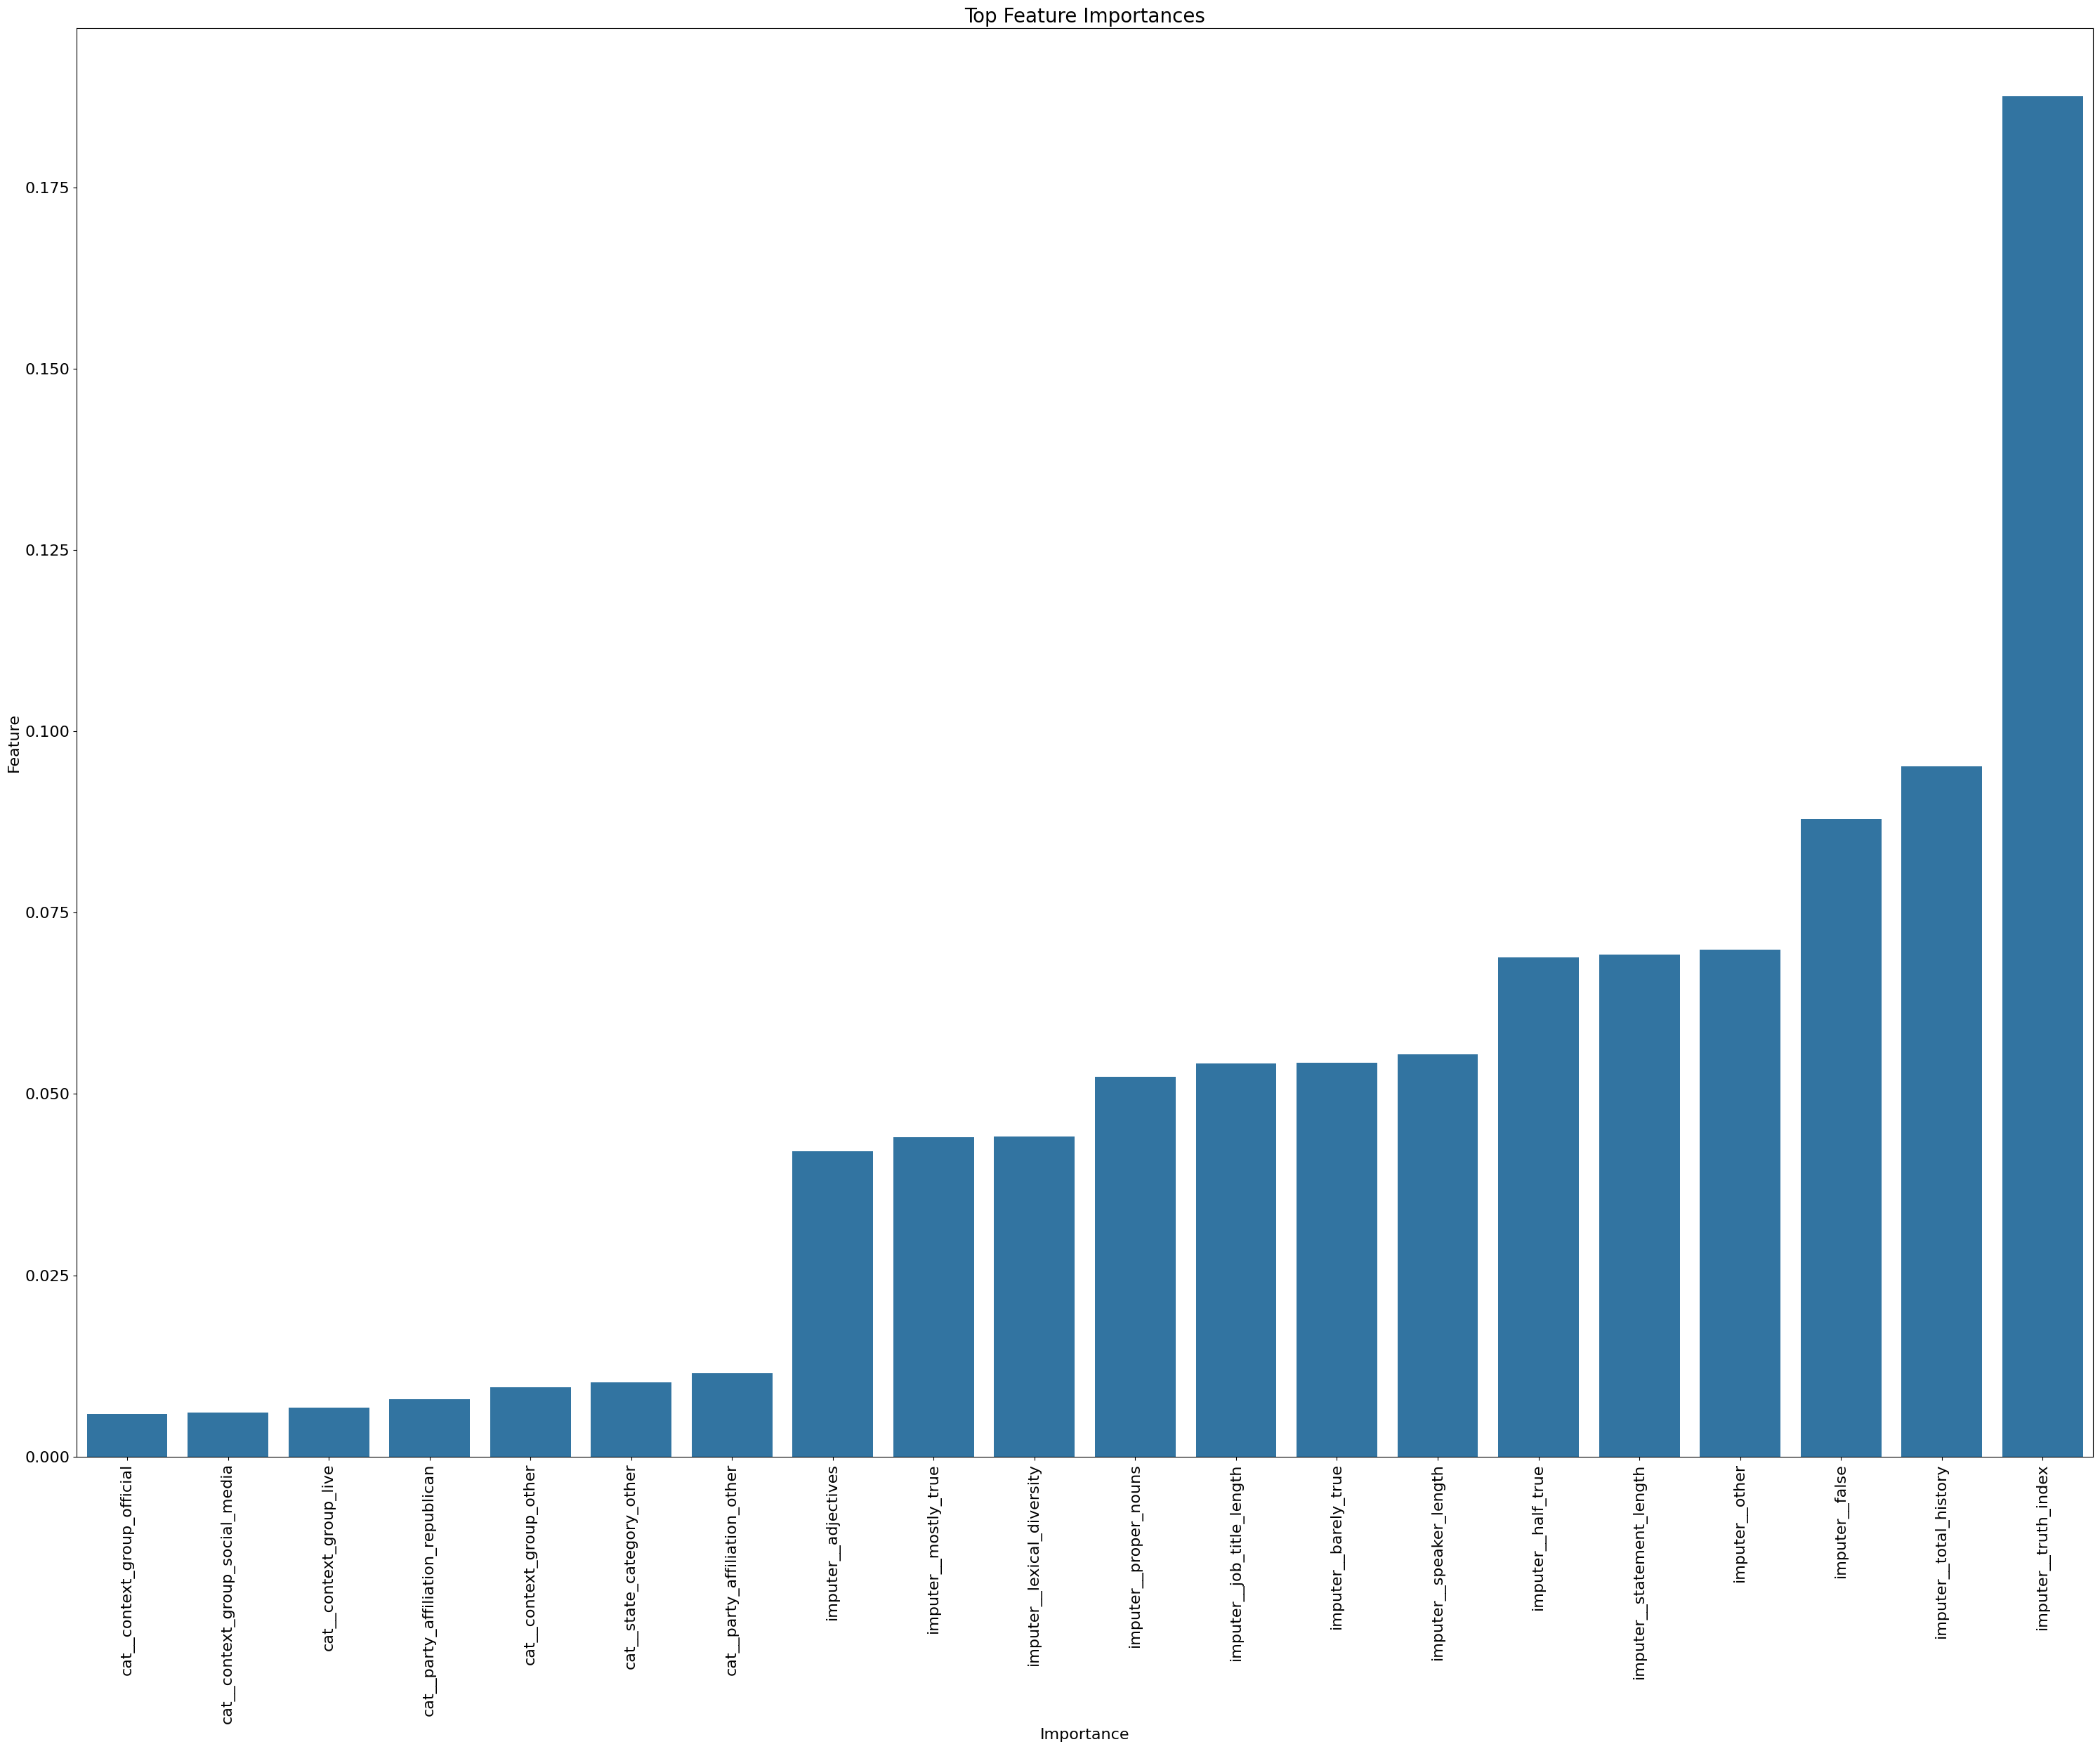

In [15]:
model = grid_search_decision_tree(X_combined.drop(columns=['statement']), y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test.drop(columns=['statement'])), "Decision Tree", model)
plot_feature_importances(model)

We see that state category has the least impace, we should try with removing it

F1 Score: 0.430


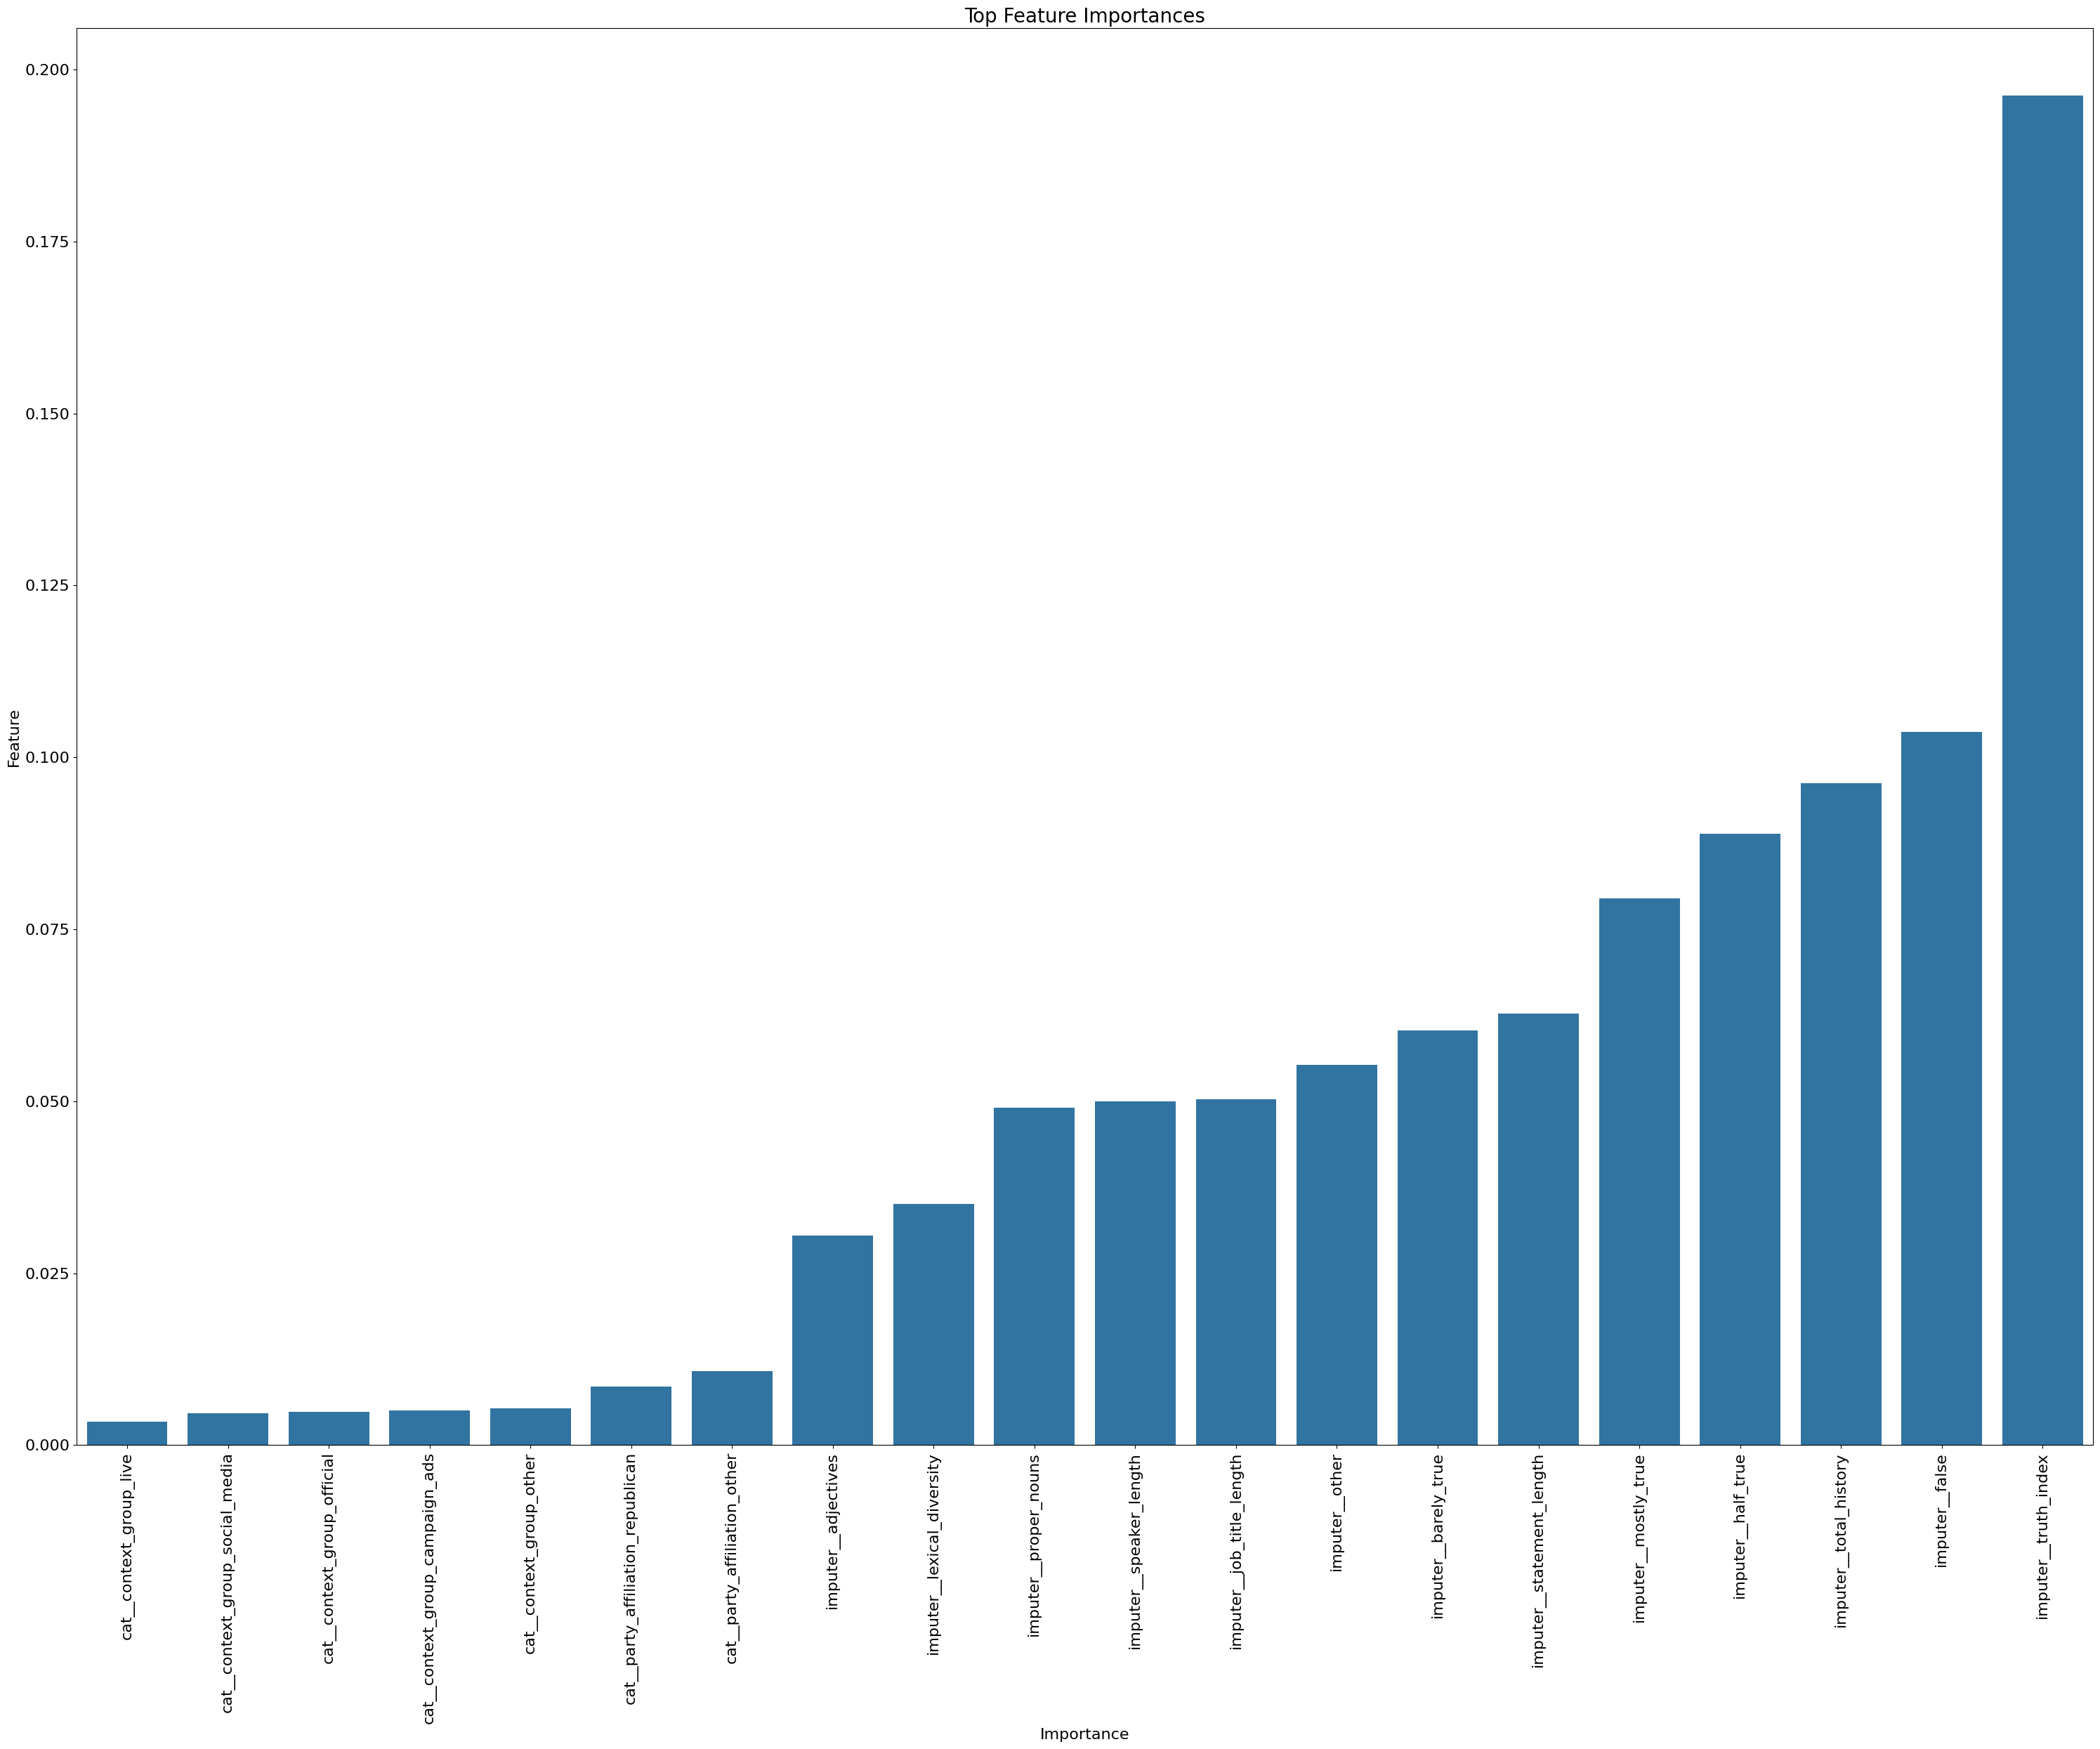

In [16]:
categorical_cols = ['context_group', 'party_affiliation']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
model = grid_search_decision_tree(X_combined.drop(columns=['statement']), y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test.drop(columns=['statement'])), "Decision Tree", model)
plot_feature_importances(model)

We see a slightly worse result, let us remove context group live.

F1 Score: 0.472


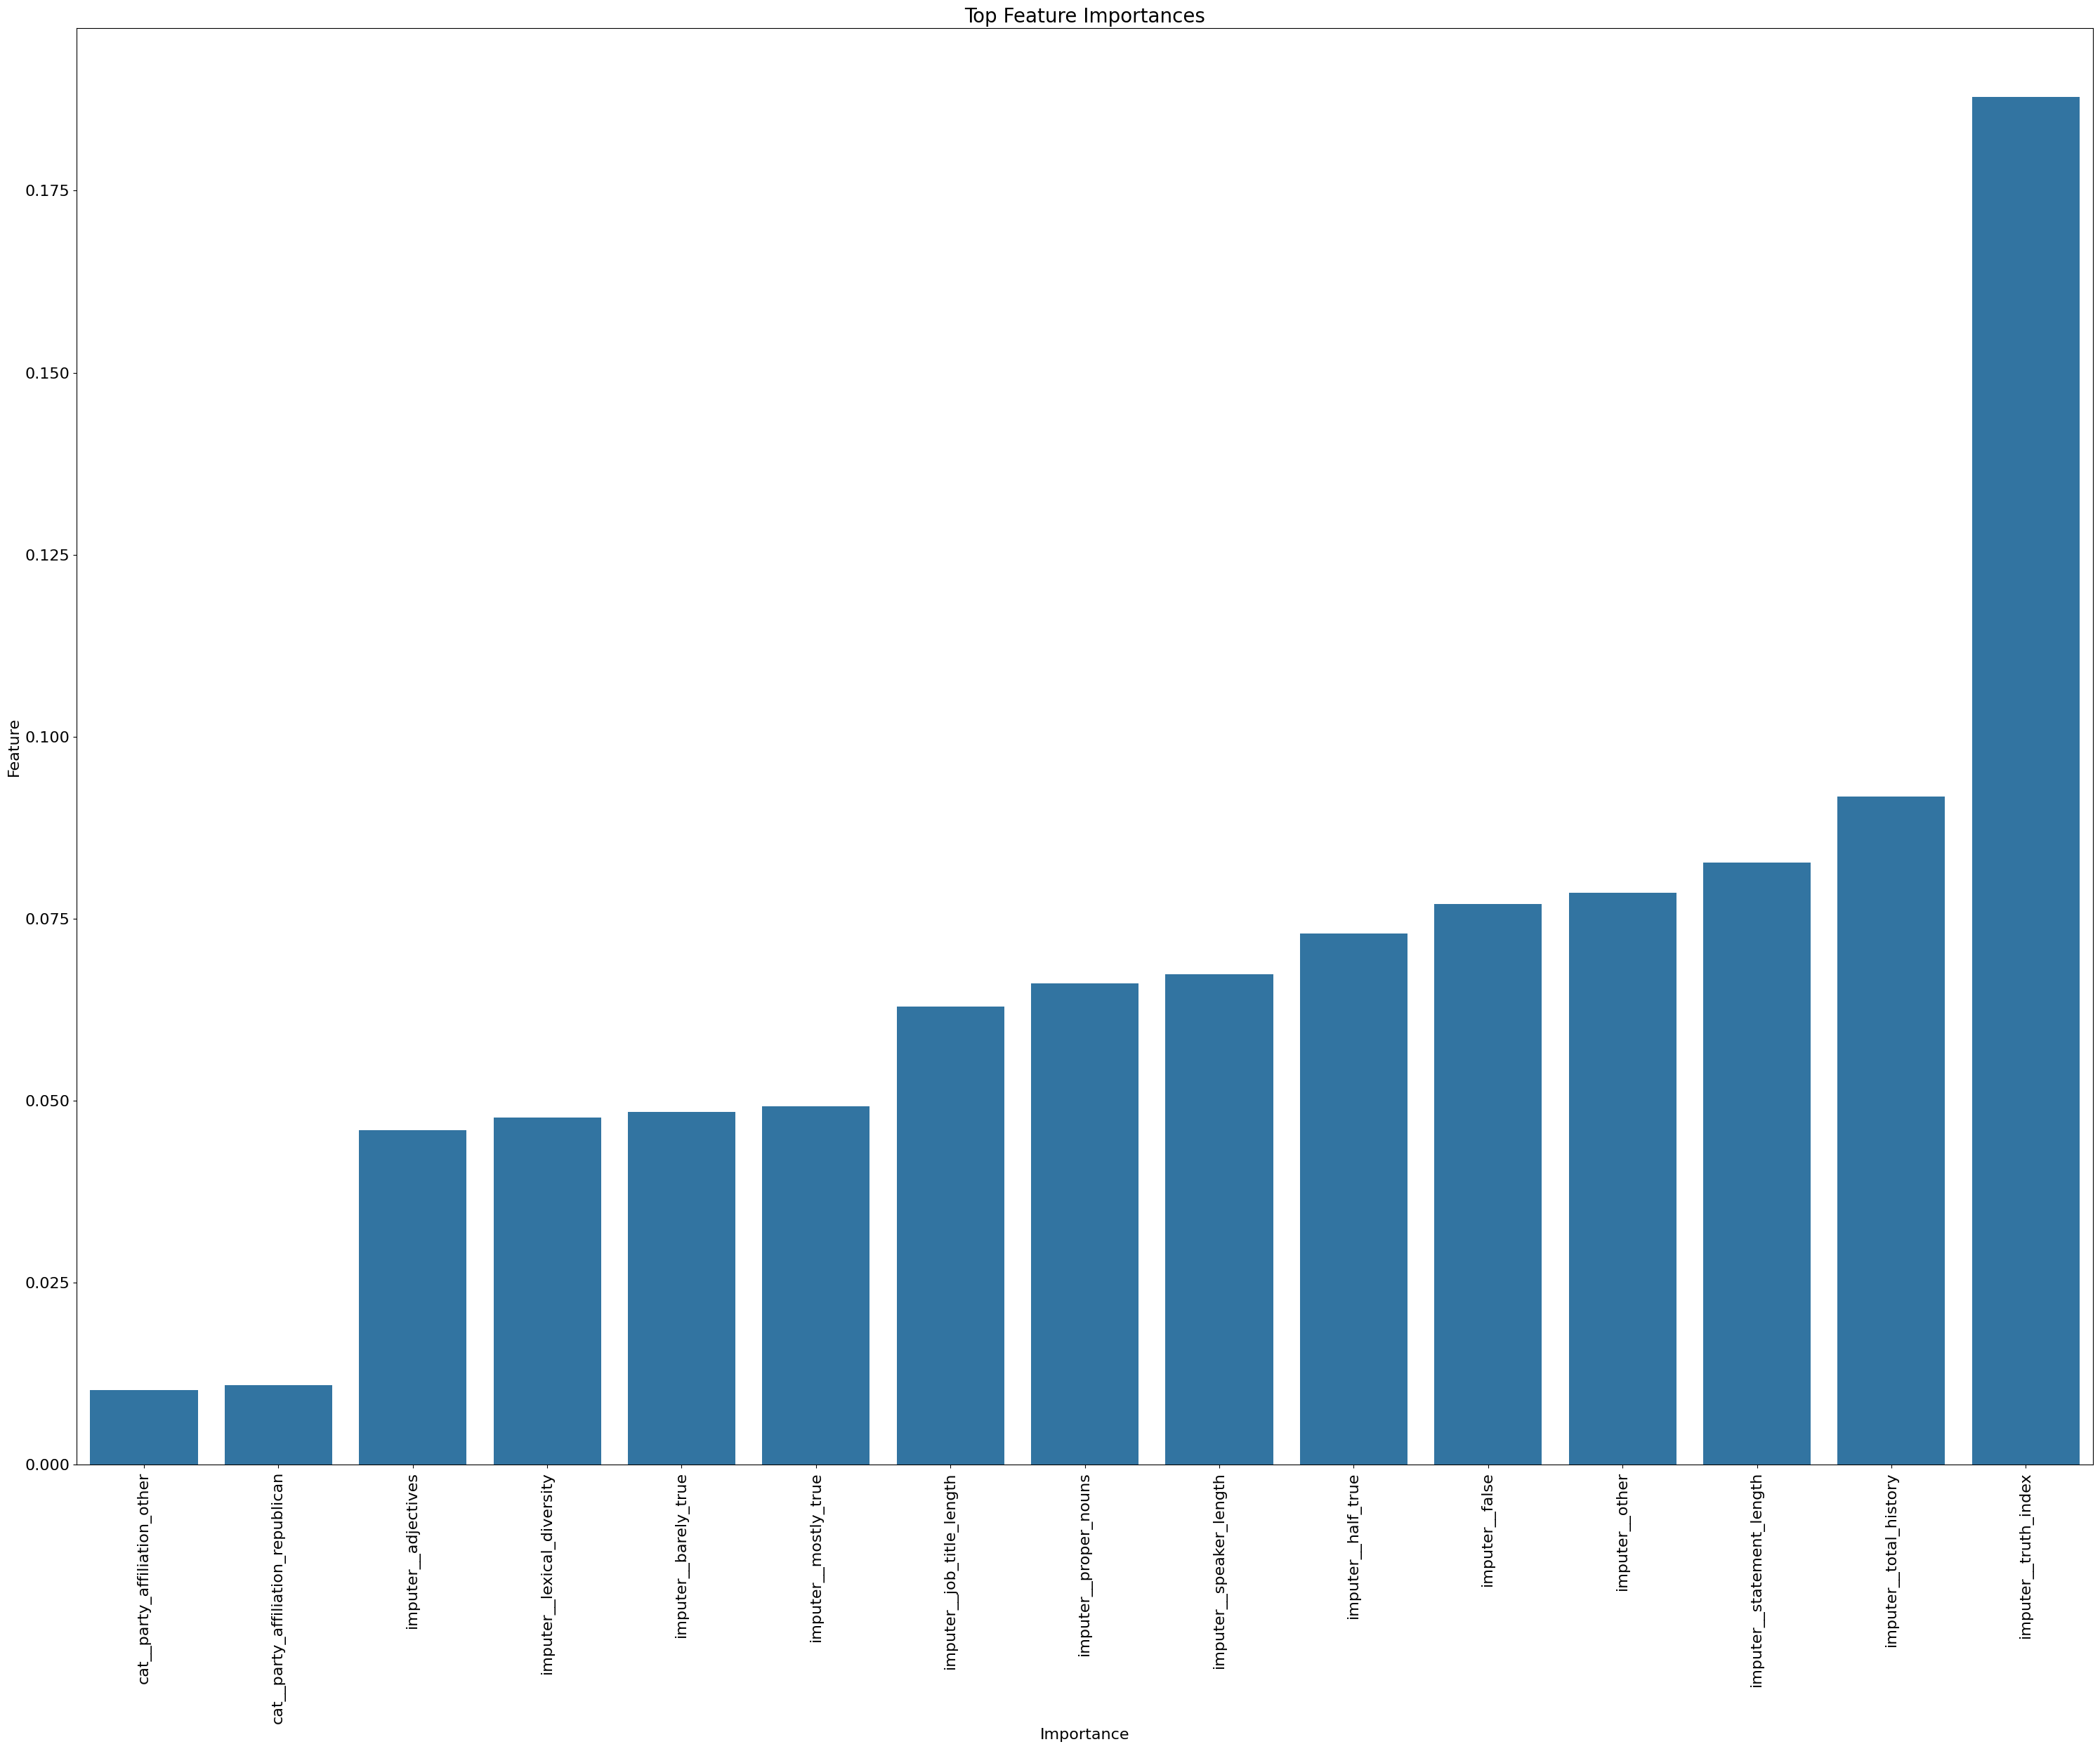

In [17]:
categorical_cols = ['party_affiliation']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
model = grid_search_decision_tree(X_combined.drop(columns=['statement']), y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test.drop(columns=['statement'])), "Decision Tree", model)
plot_feature_importances(model)

We see an improved result, we will try with adding state_category

F1 Score: 0.482


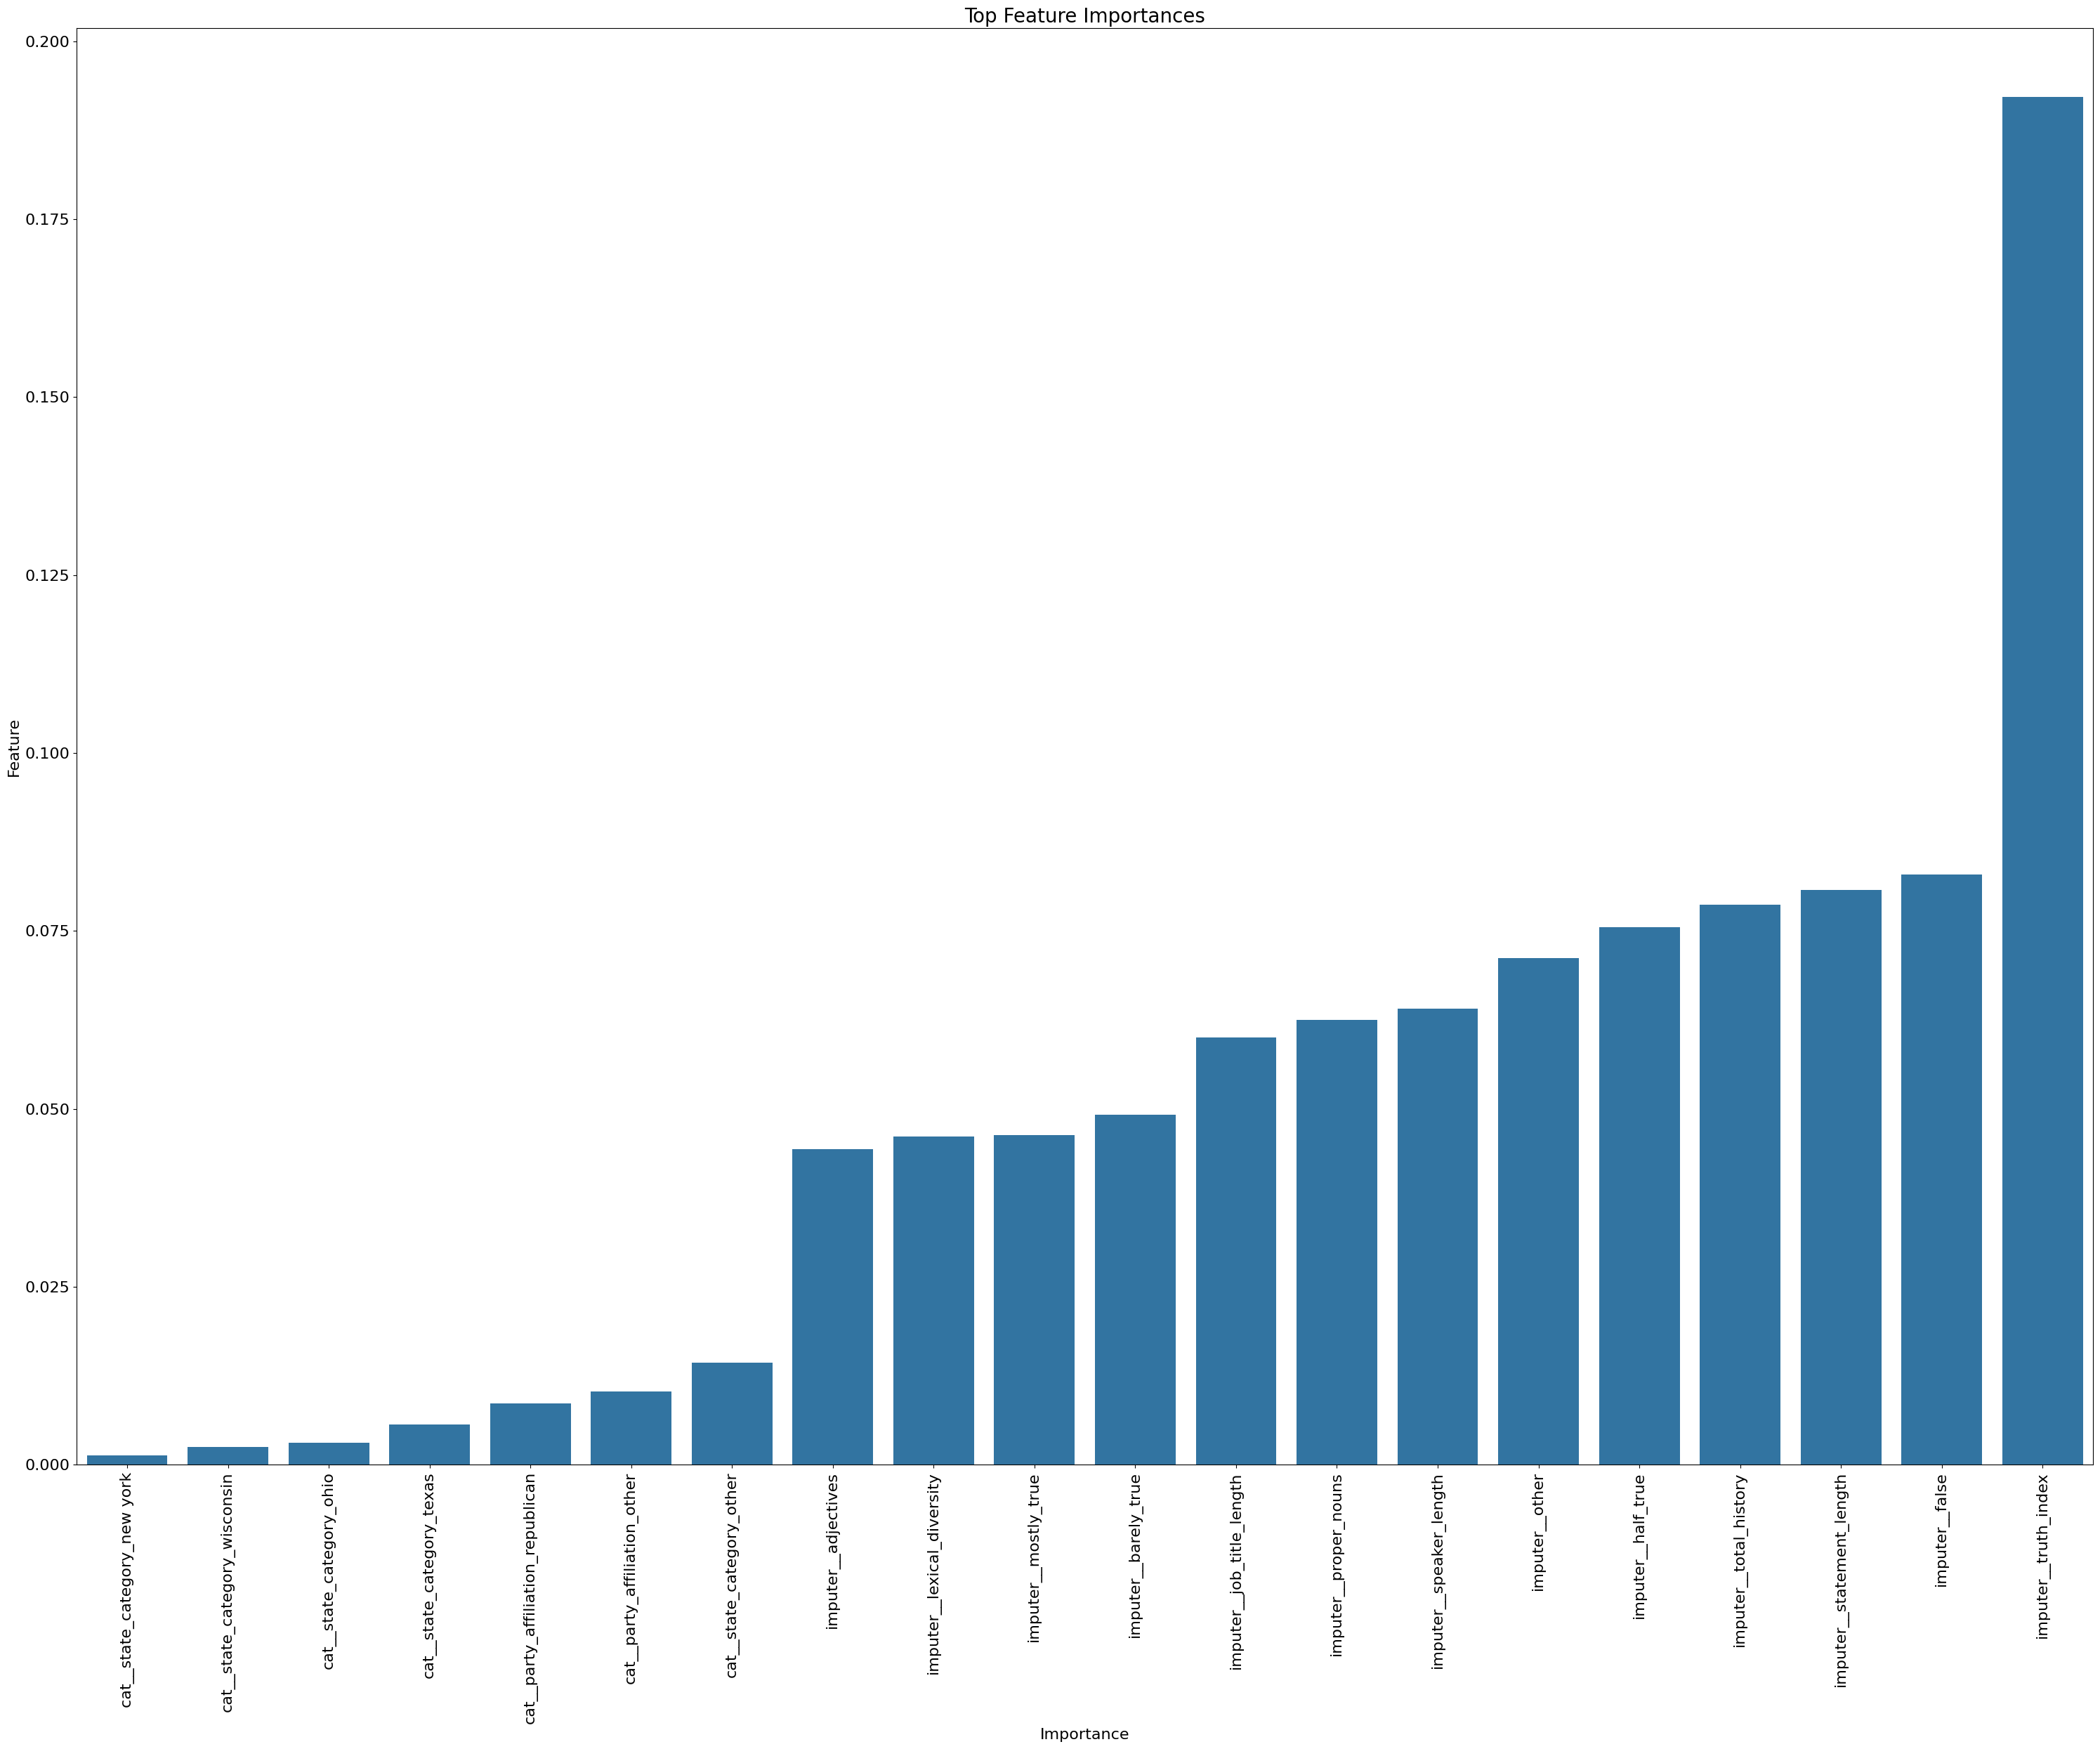

In [18]:
categorical_cols = ['state_category', 'party_affiliation']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
model = grid_search_decision_tree(X_combined.drop(columns=['statement']), y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test.drop(columns=['statement'])), "Decision Tree", model)
plot_feature_importances(model)

We will try removing the third cat column

F1 Score: 0.465


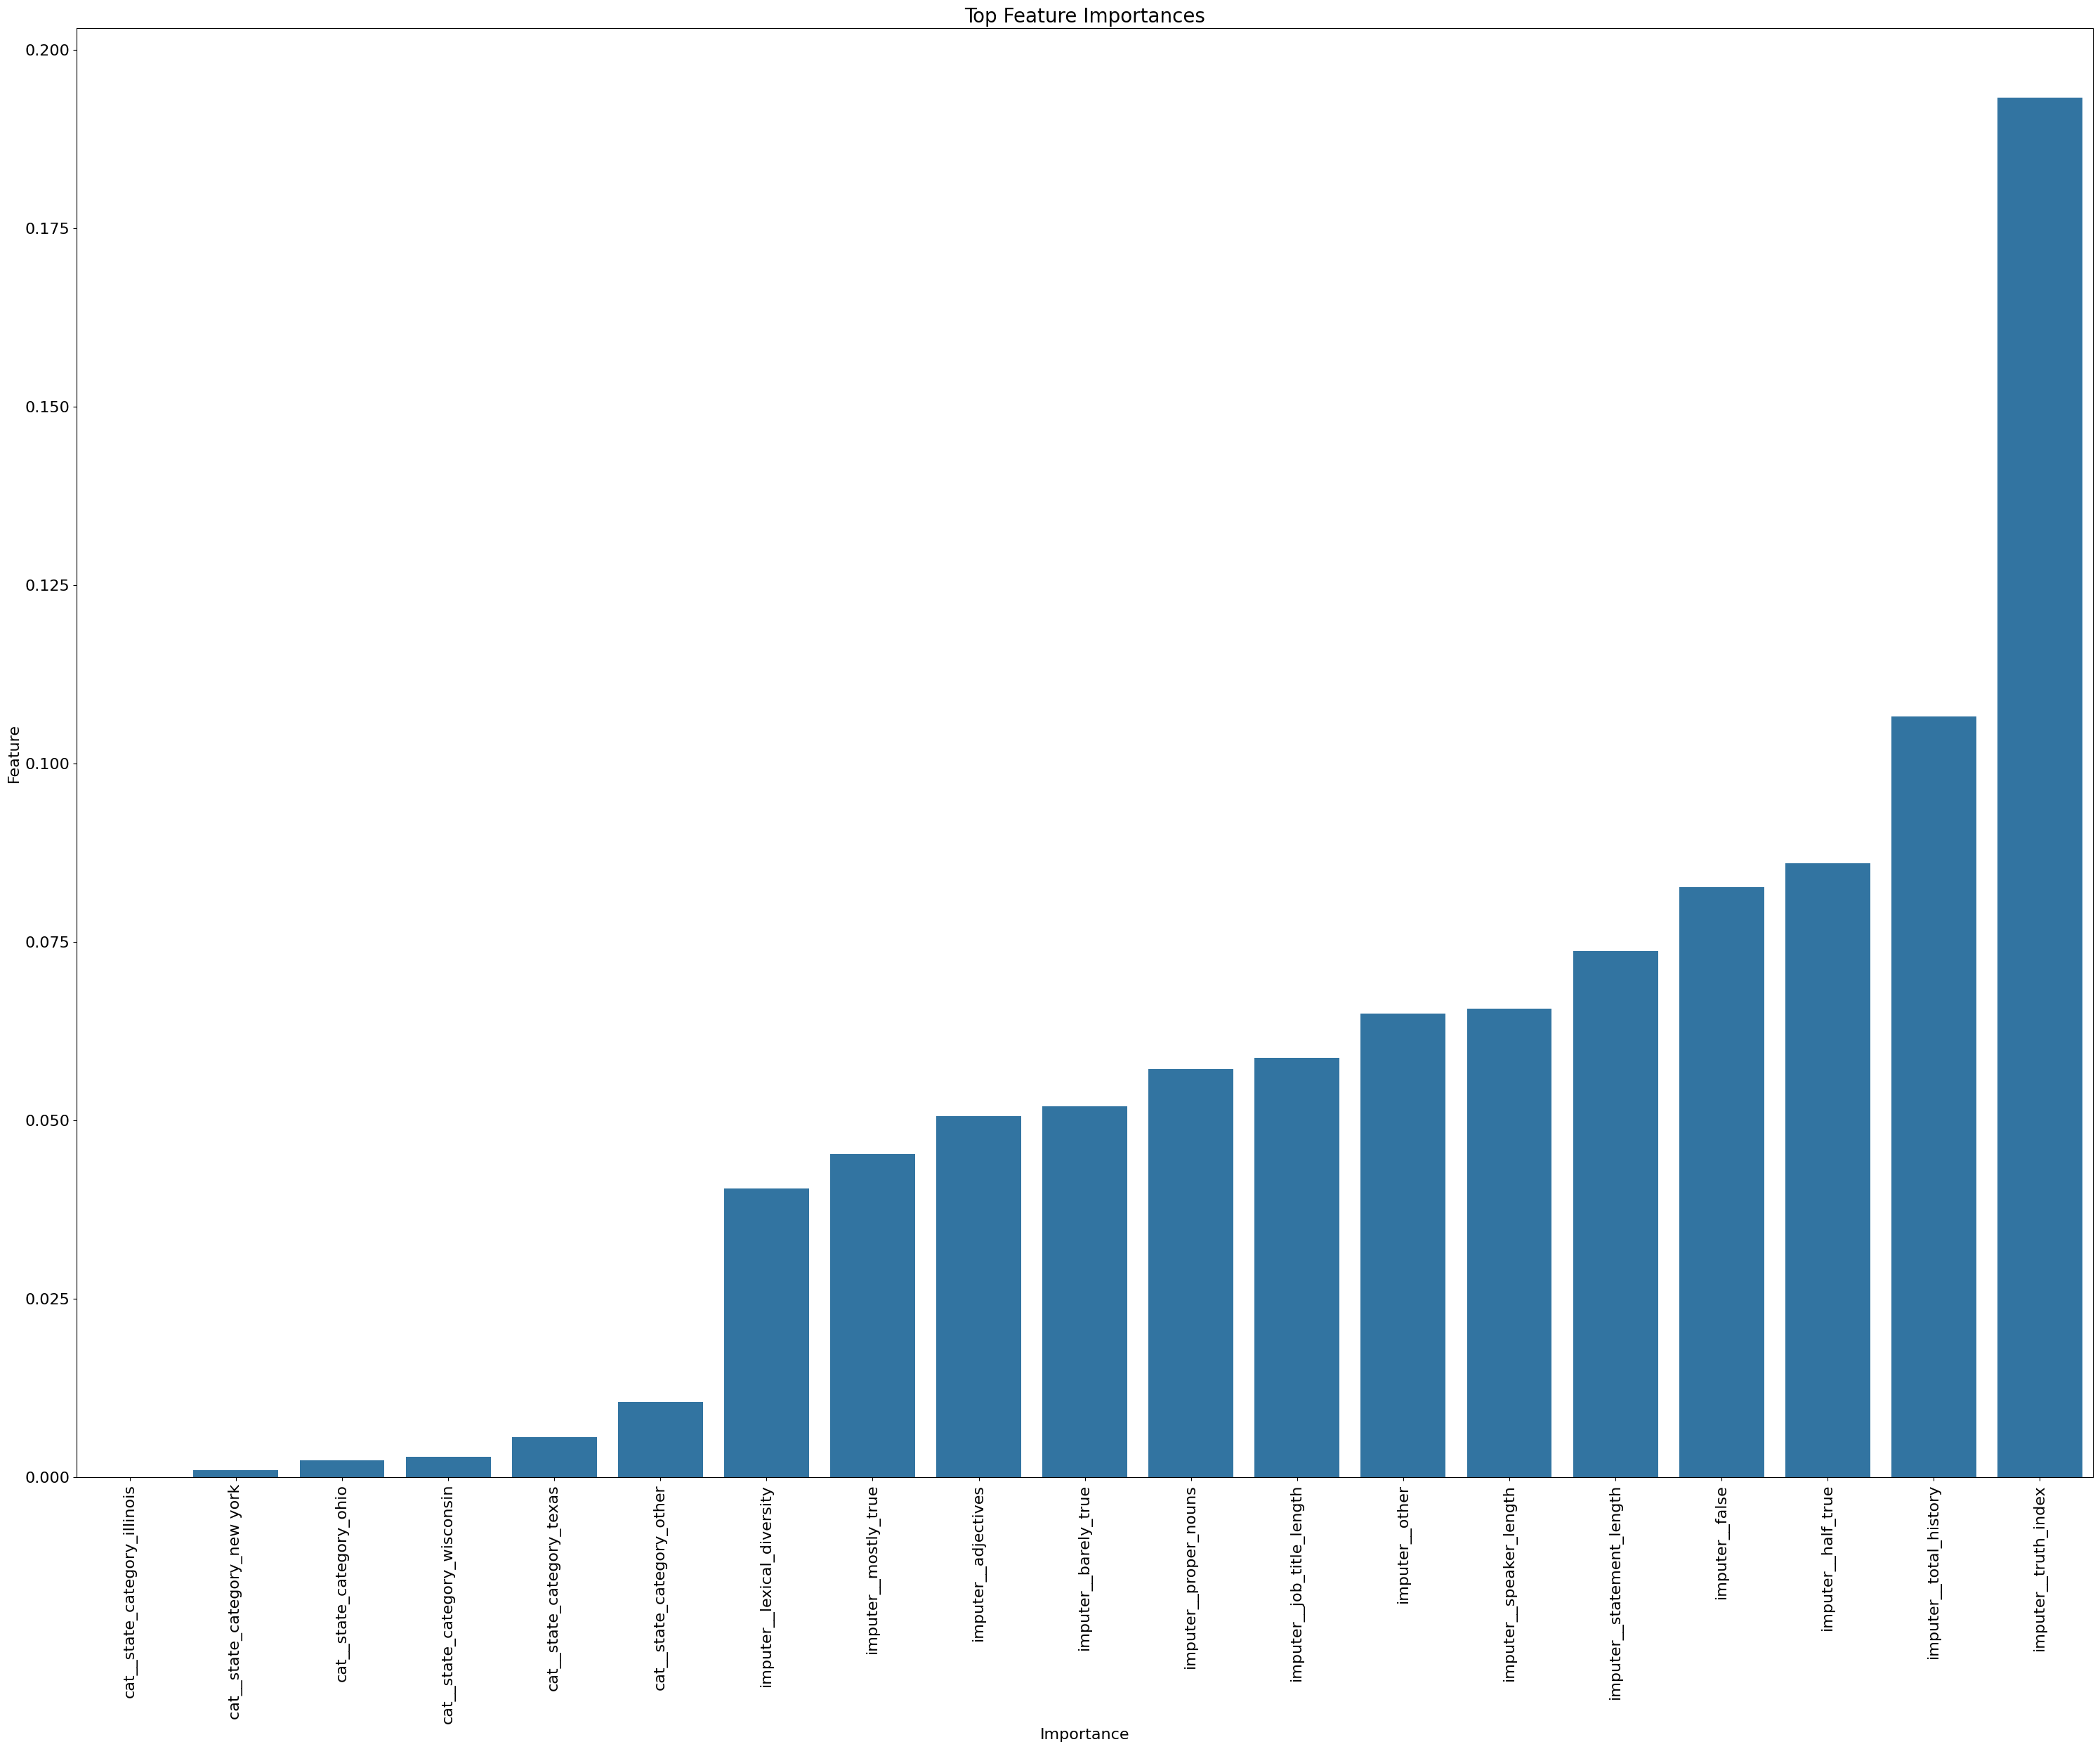

In [19]:
categorical_cols = ['state_category']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
model = grid_search_decision_tree(X_combined.drop(columns=['statement']), y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test.drop(columns=['statement'])), "Decision Tree", model)
plot_feature_importances(model)

We will try removing the least important num column from the best model until now- adjectives

F1 Score: 0.471


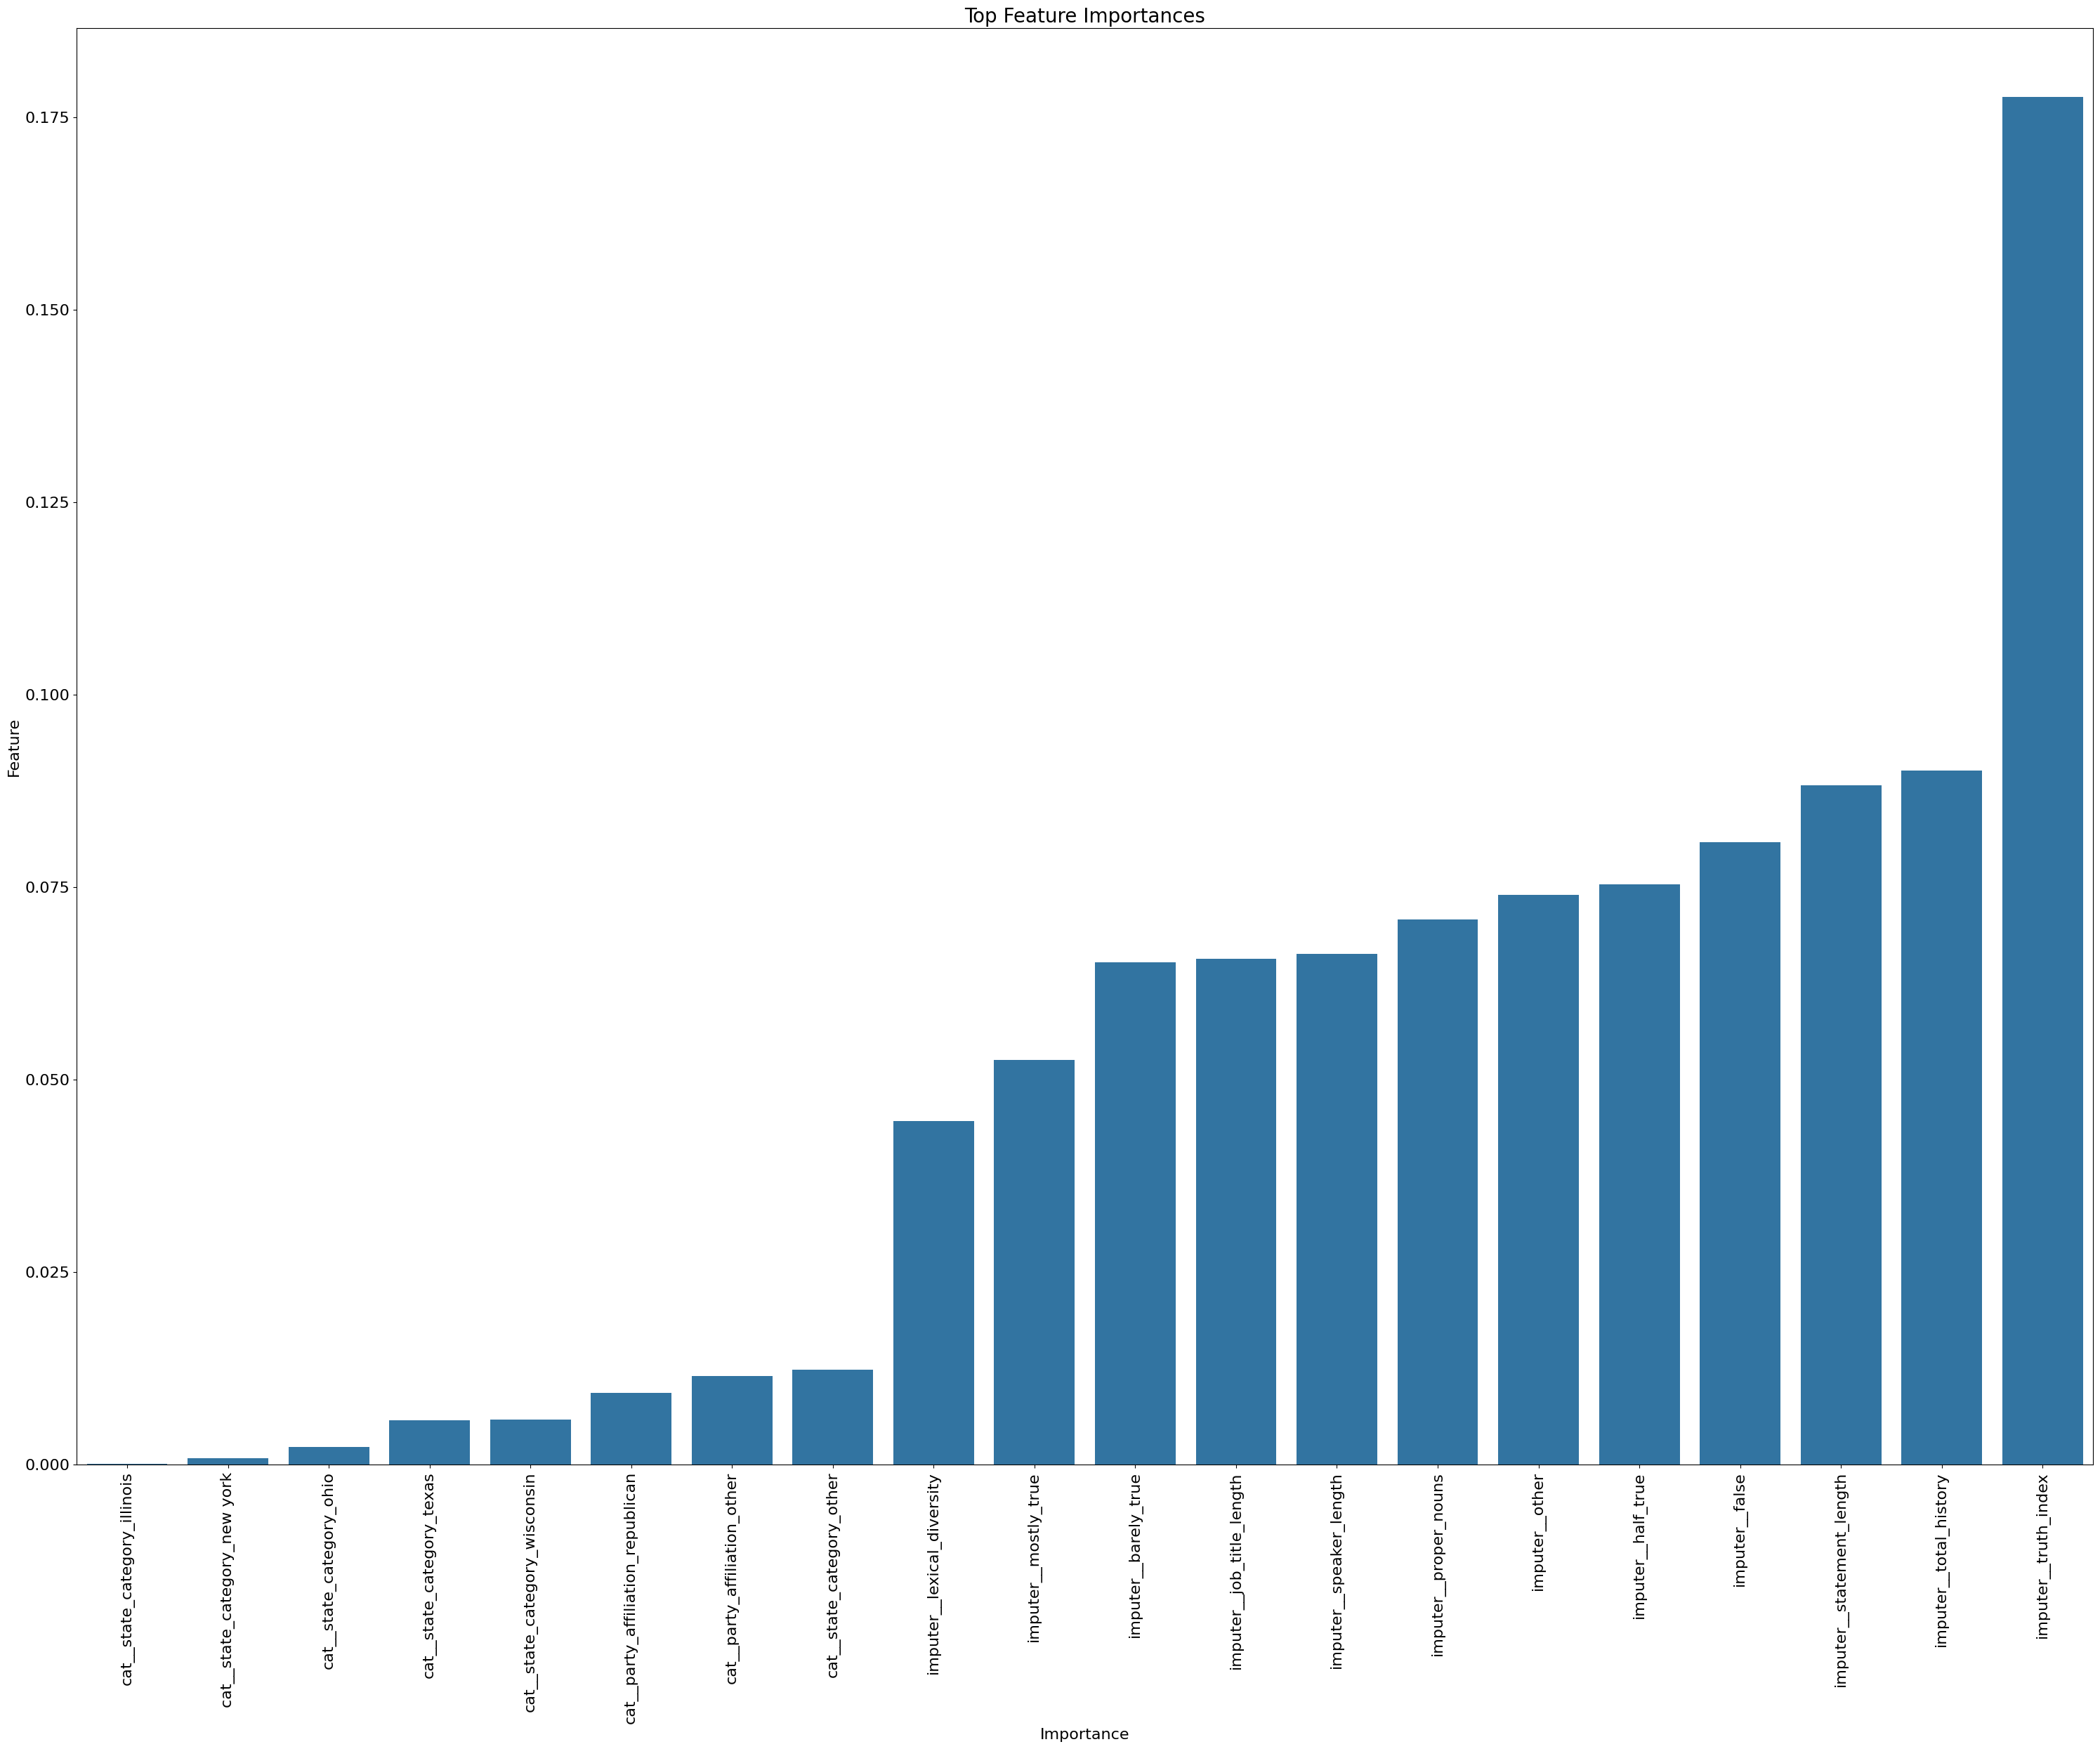

In [20]:
categorical_cols = ['state_category', 'party_affiliation']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('adjectives')
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
model = grid_search_decision_tree(X_combined.drop(columns=['statement']), y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test.drop(columns=['statement'])), "Decision Tree", model)
plot_feature_importances(model)

We see decrease of performance. Just for the experiment, we will see what removing truth_index will look like

F1 Score: 0.405


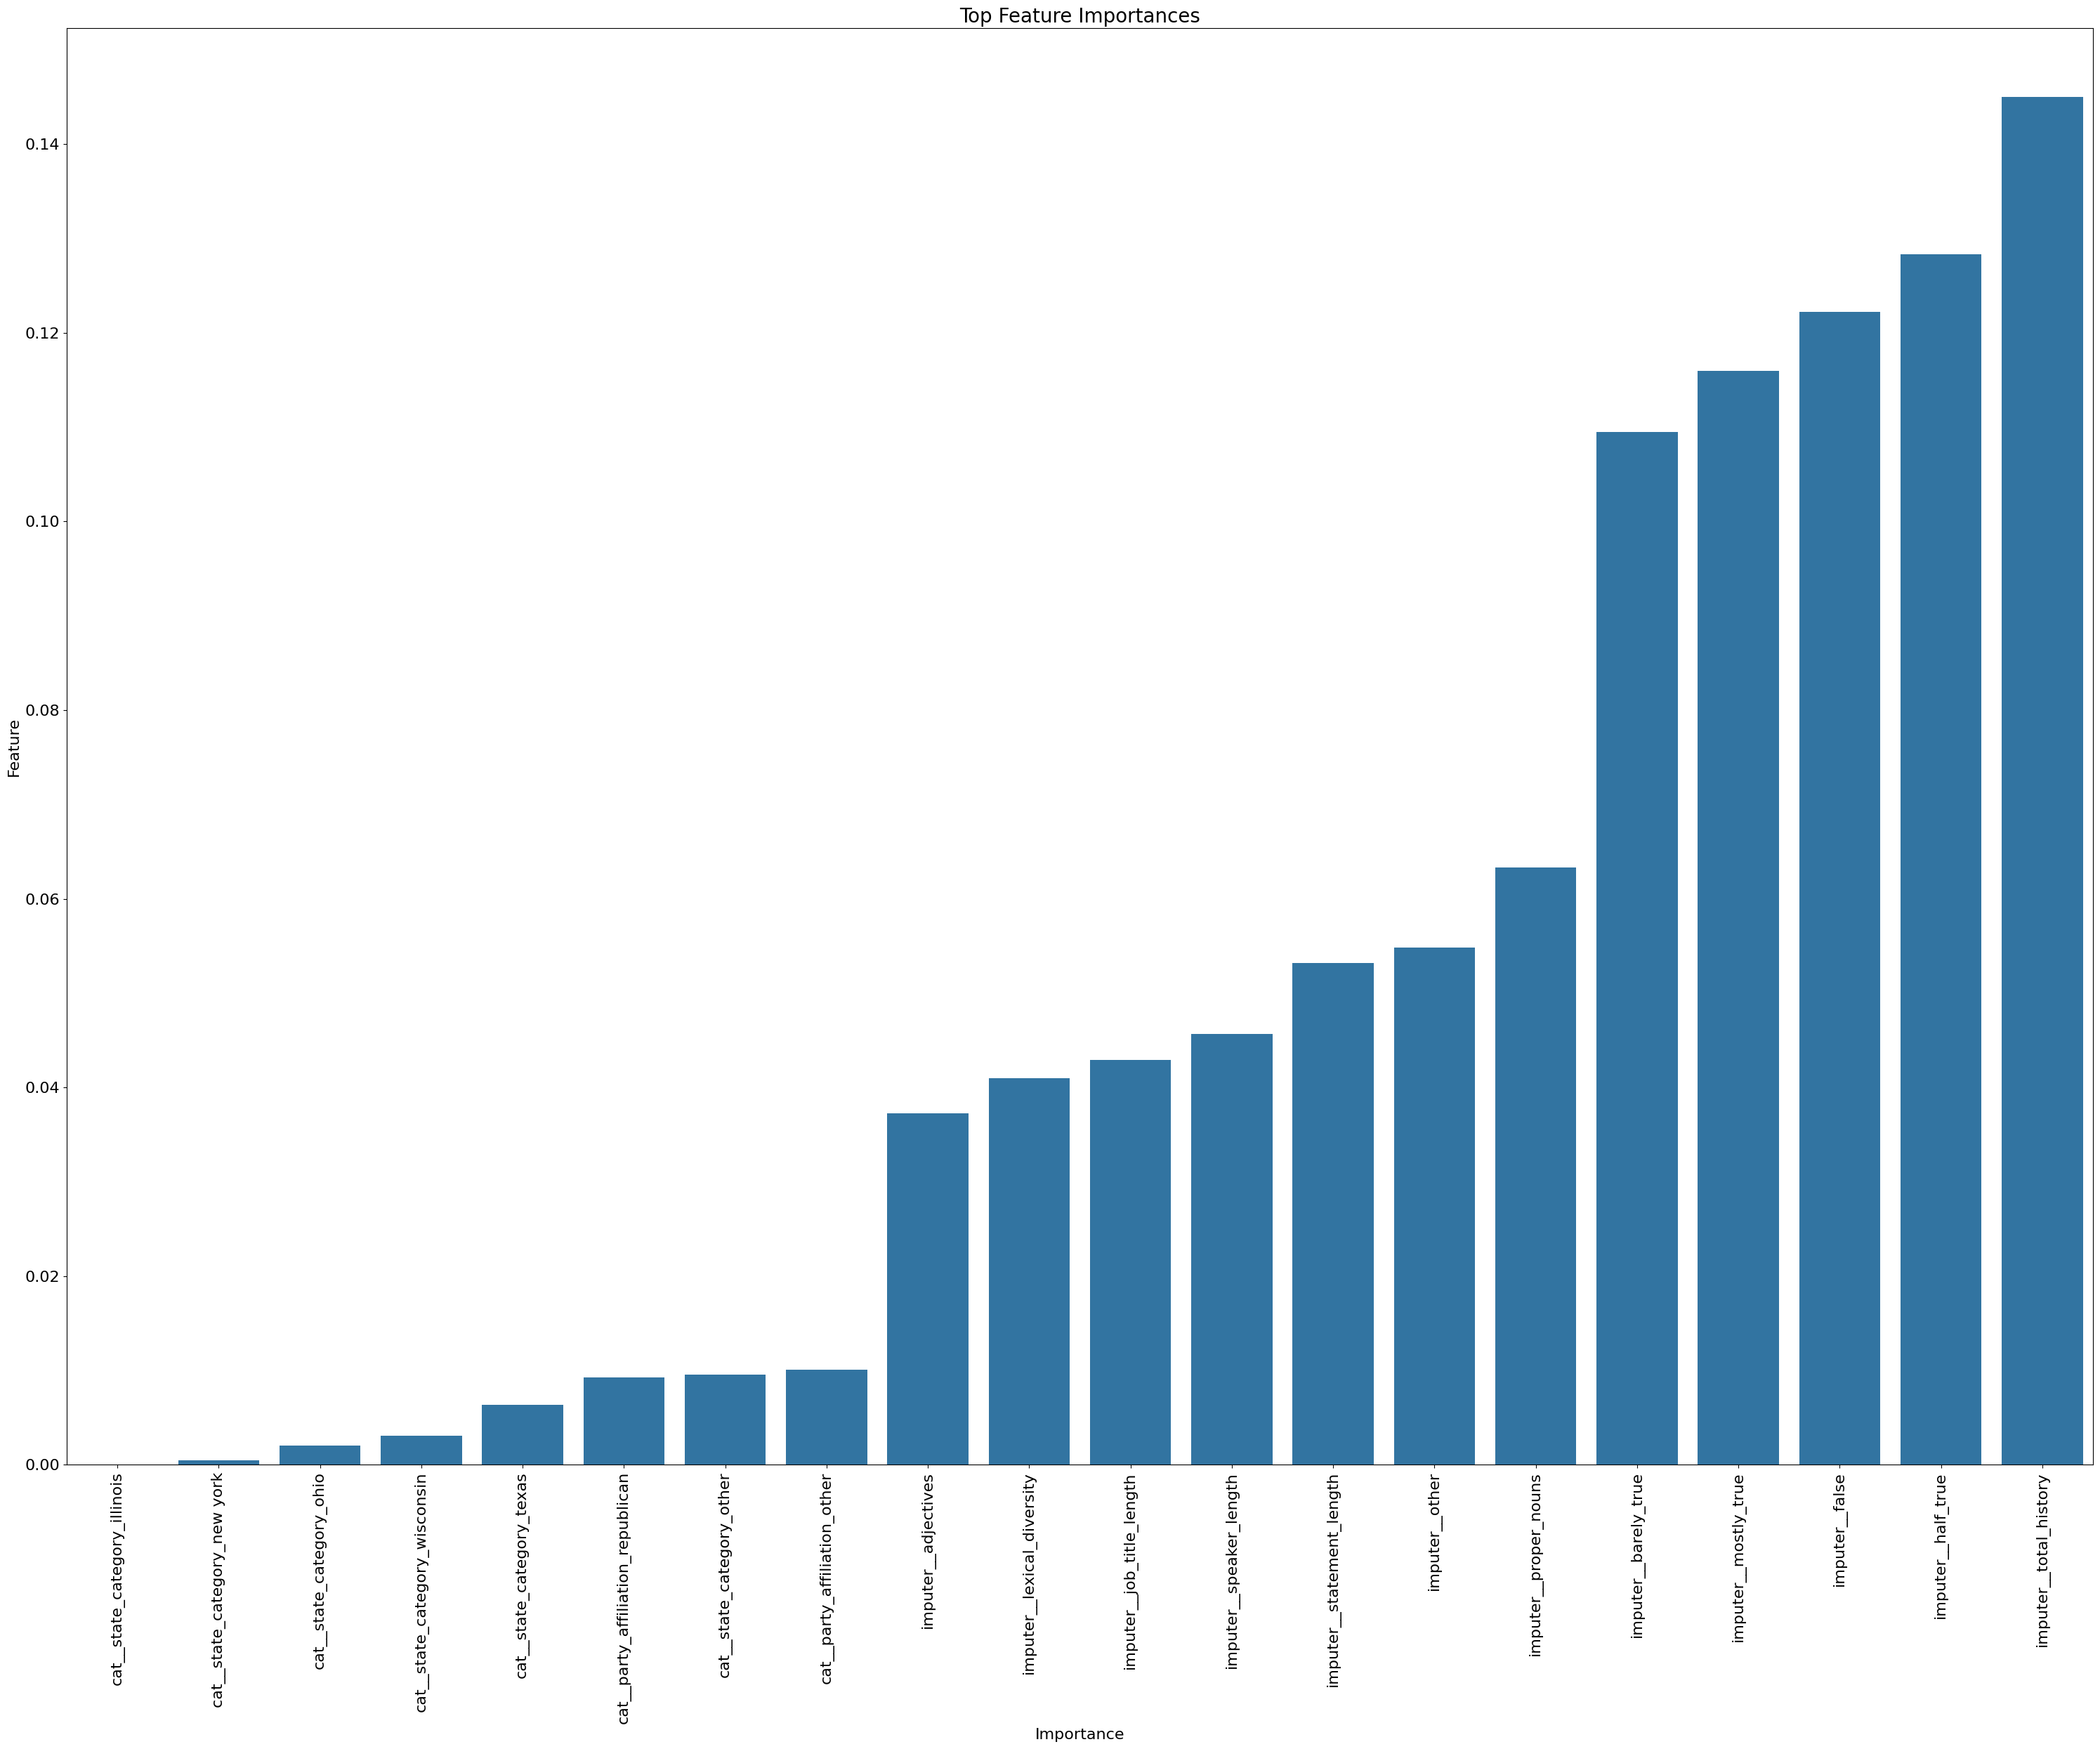

In [21]:
categorical_cols = ['state_category', 'party_affiliation']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('truth_index')
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
model = grid_search_decision_tree(X_combined.drop(columns=['statement']), y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test.drop(columns=['statement'])), "Decision Tree", model)
plot_feature_importances(model)

So it looks like we need it but not that much. Let us try with different imputer(only job_title column has missing values)

F1 Score: 0.481


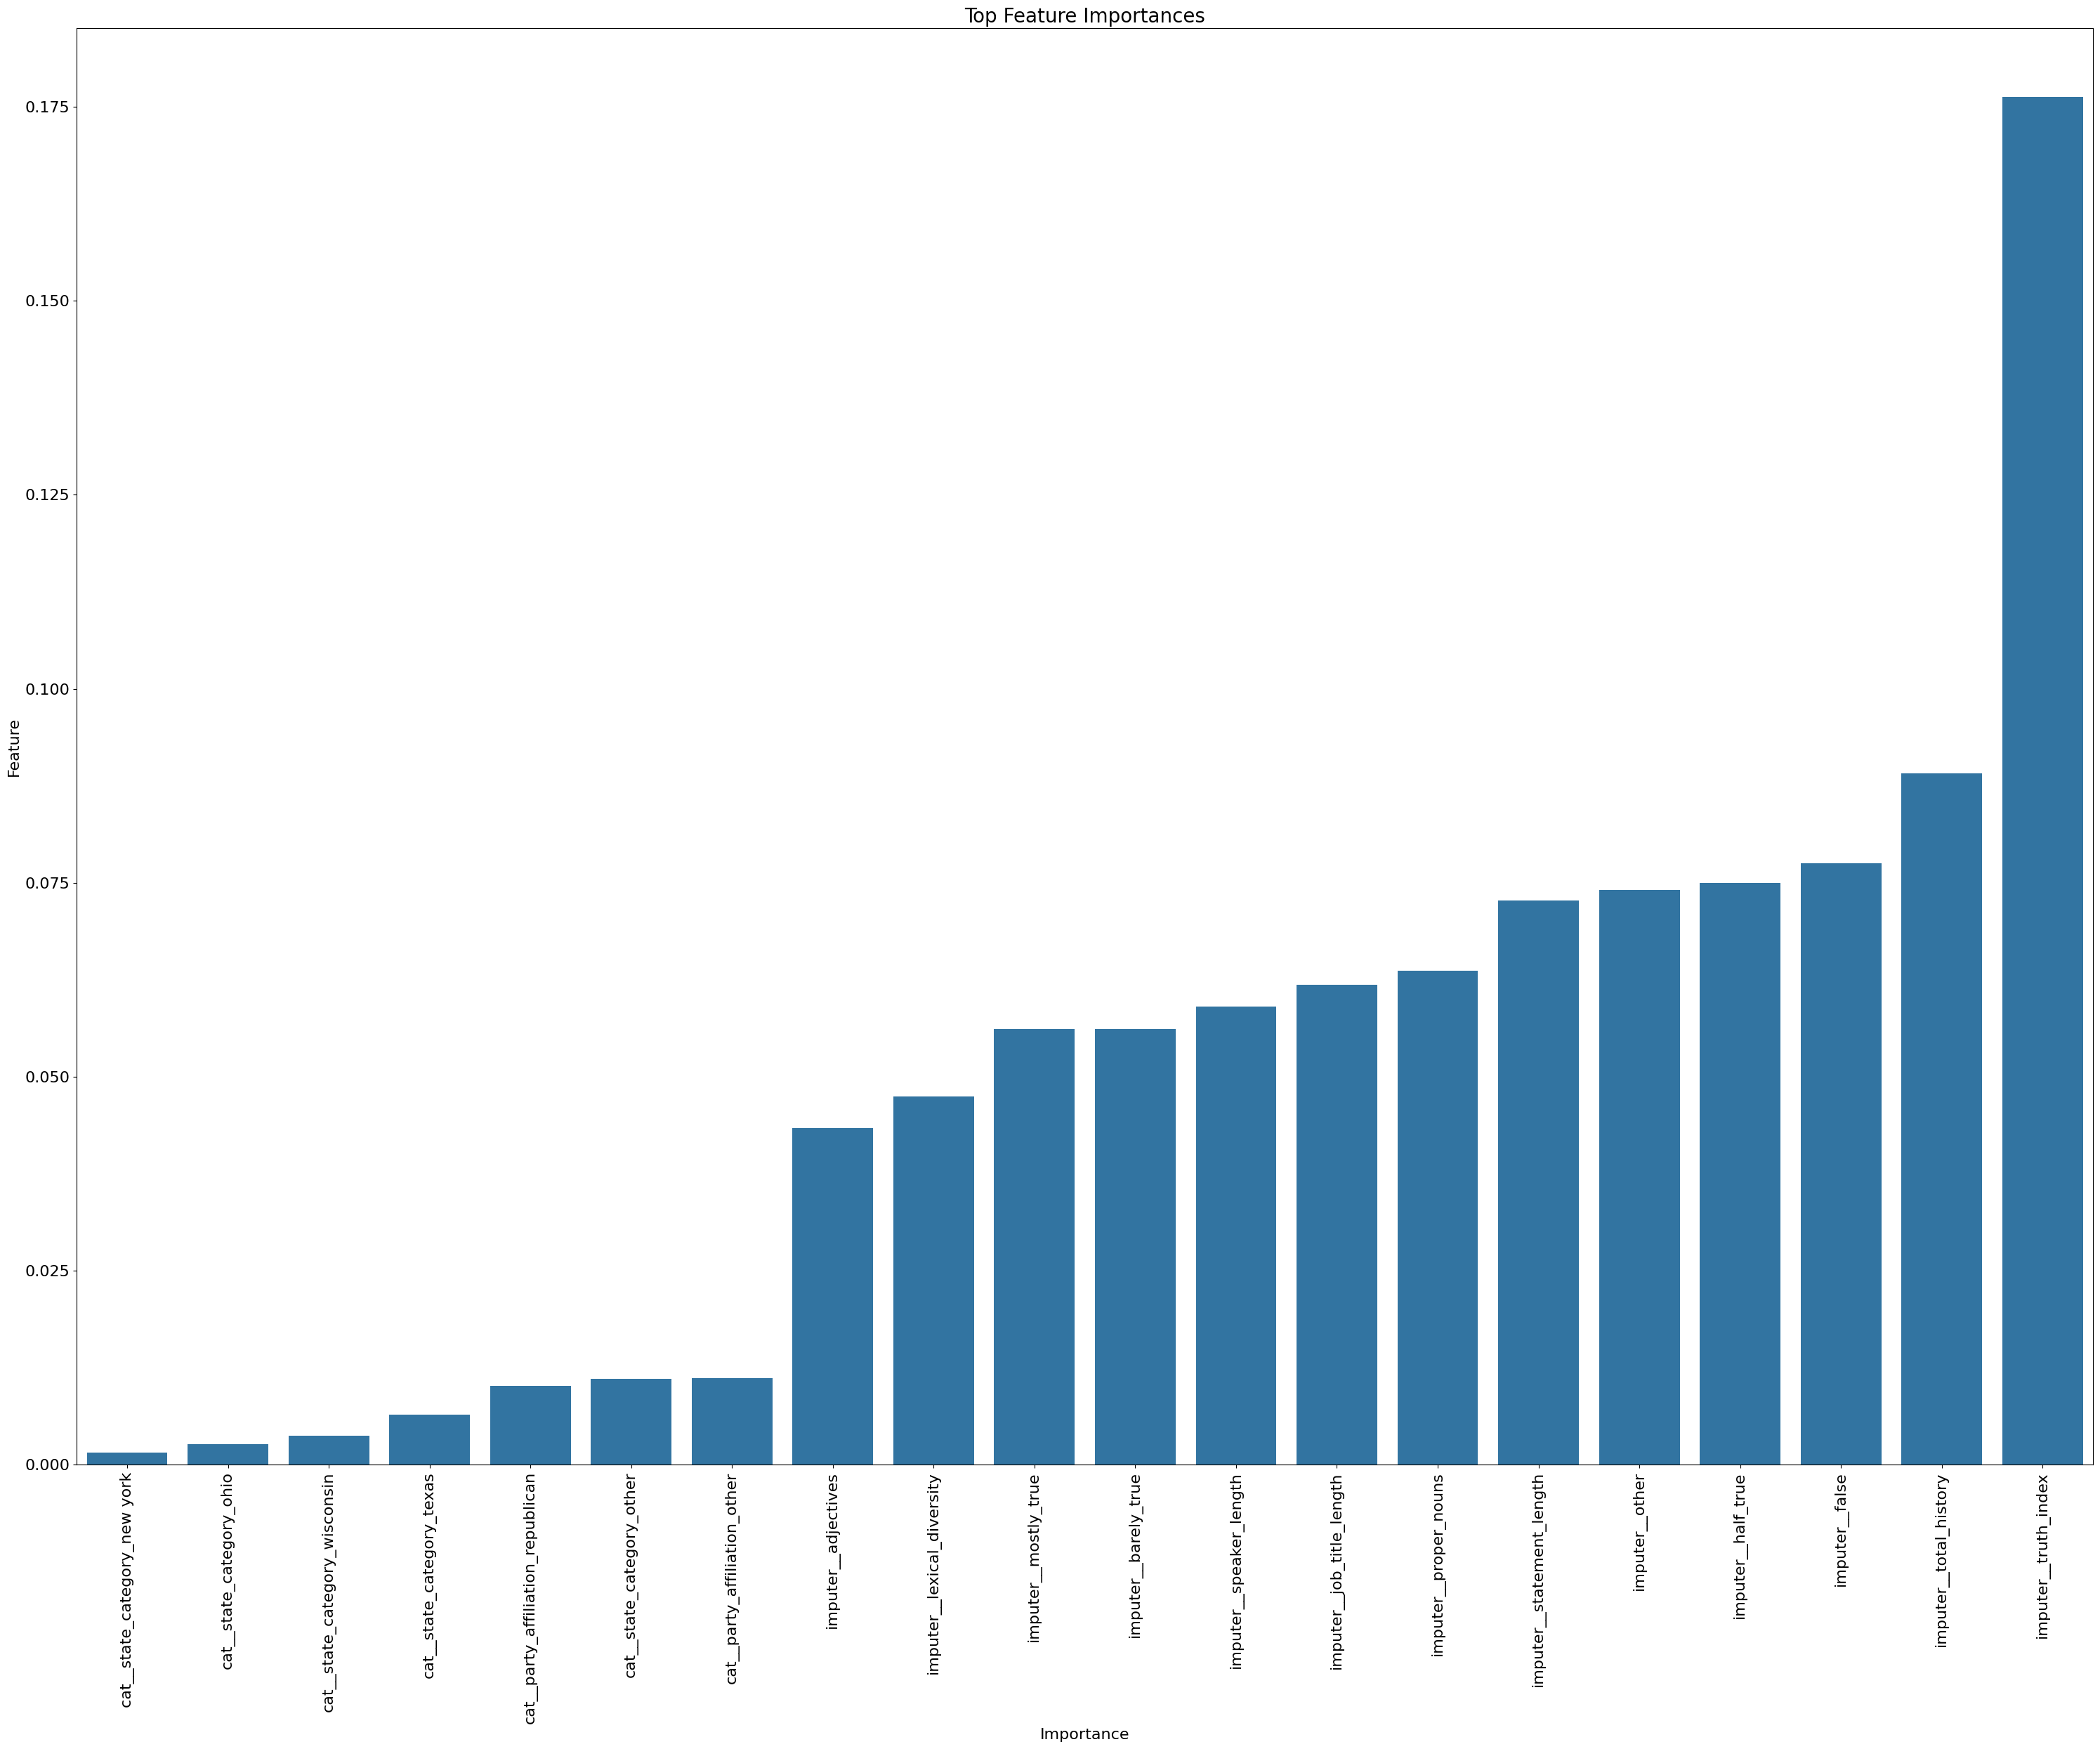

In [22]:
categorical_cols = ['state_category', 'party_affiliation']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='constant', fill_value=0), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
model = grid_search_decision_tree(X_combined.drop(columns=['statement']), y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test.drop(columns=['statement'])), "Decision Tree", model)
plot_feature_importances(model)

We get a worse result, but by a very little, so median strategy may be the one that remains. Now we should see what we can do with the statement column

F1 Score: 0.206


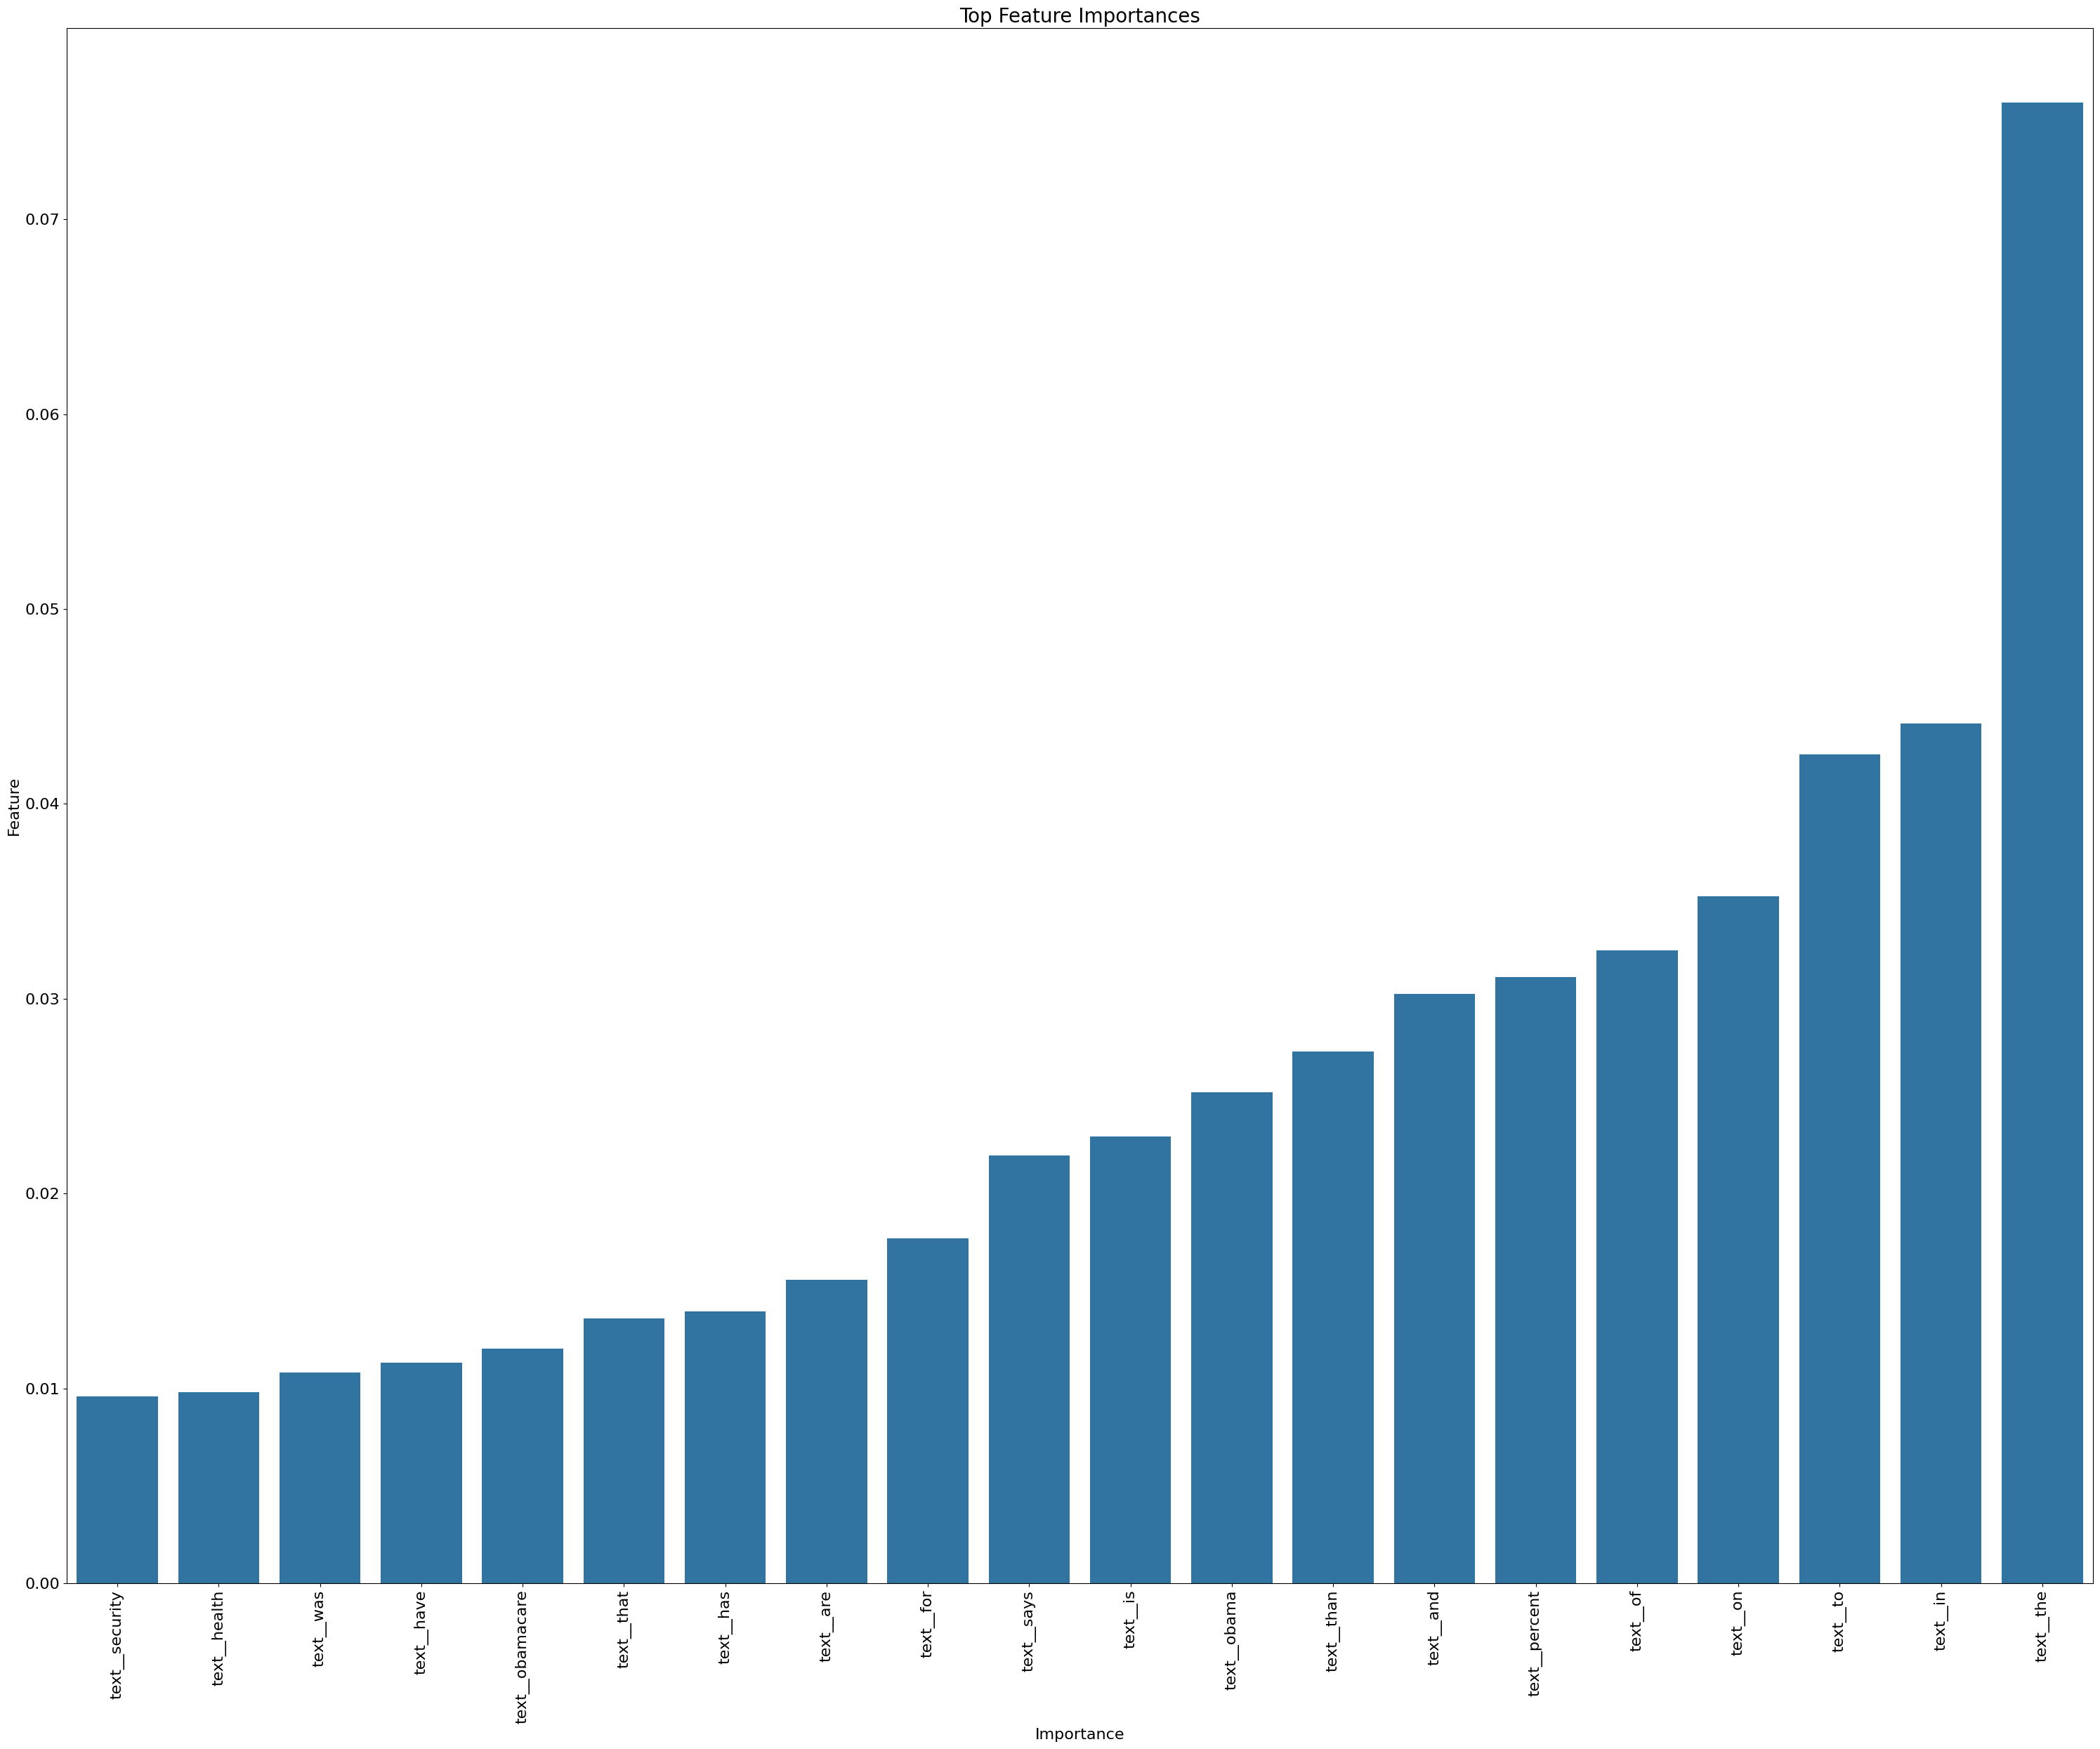

In [23]:
categorical_cols = ['state_category', 'party_affiliation']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'statement')
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
model = grid_search_decision_tree(X_combined, y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test), "Decision Tree", model)
plot_feature_importances(model)

Let us try with a Count Vectorizer

In [24]:
categorical_cols = ['state_category', 'party_affiliation']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('text', CountVectorizer(), 'statement')
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
model = grid_search_decision_tree(X_combined, y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test), "Decision Tree", model)

F1 Score: 0.205


We get practically the same result. We should combine it with the numerical features

F1 Score: 0.472


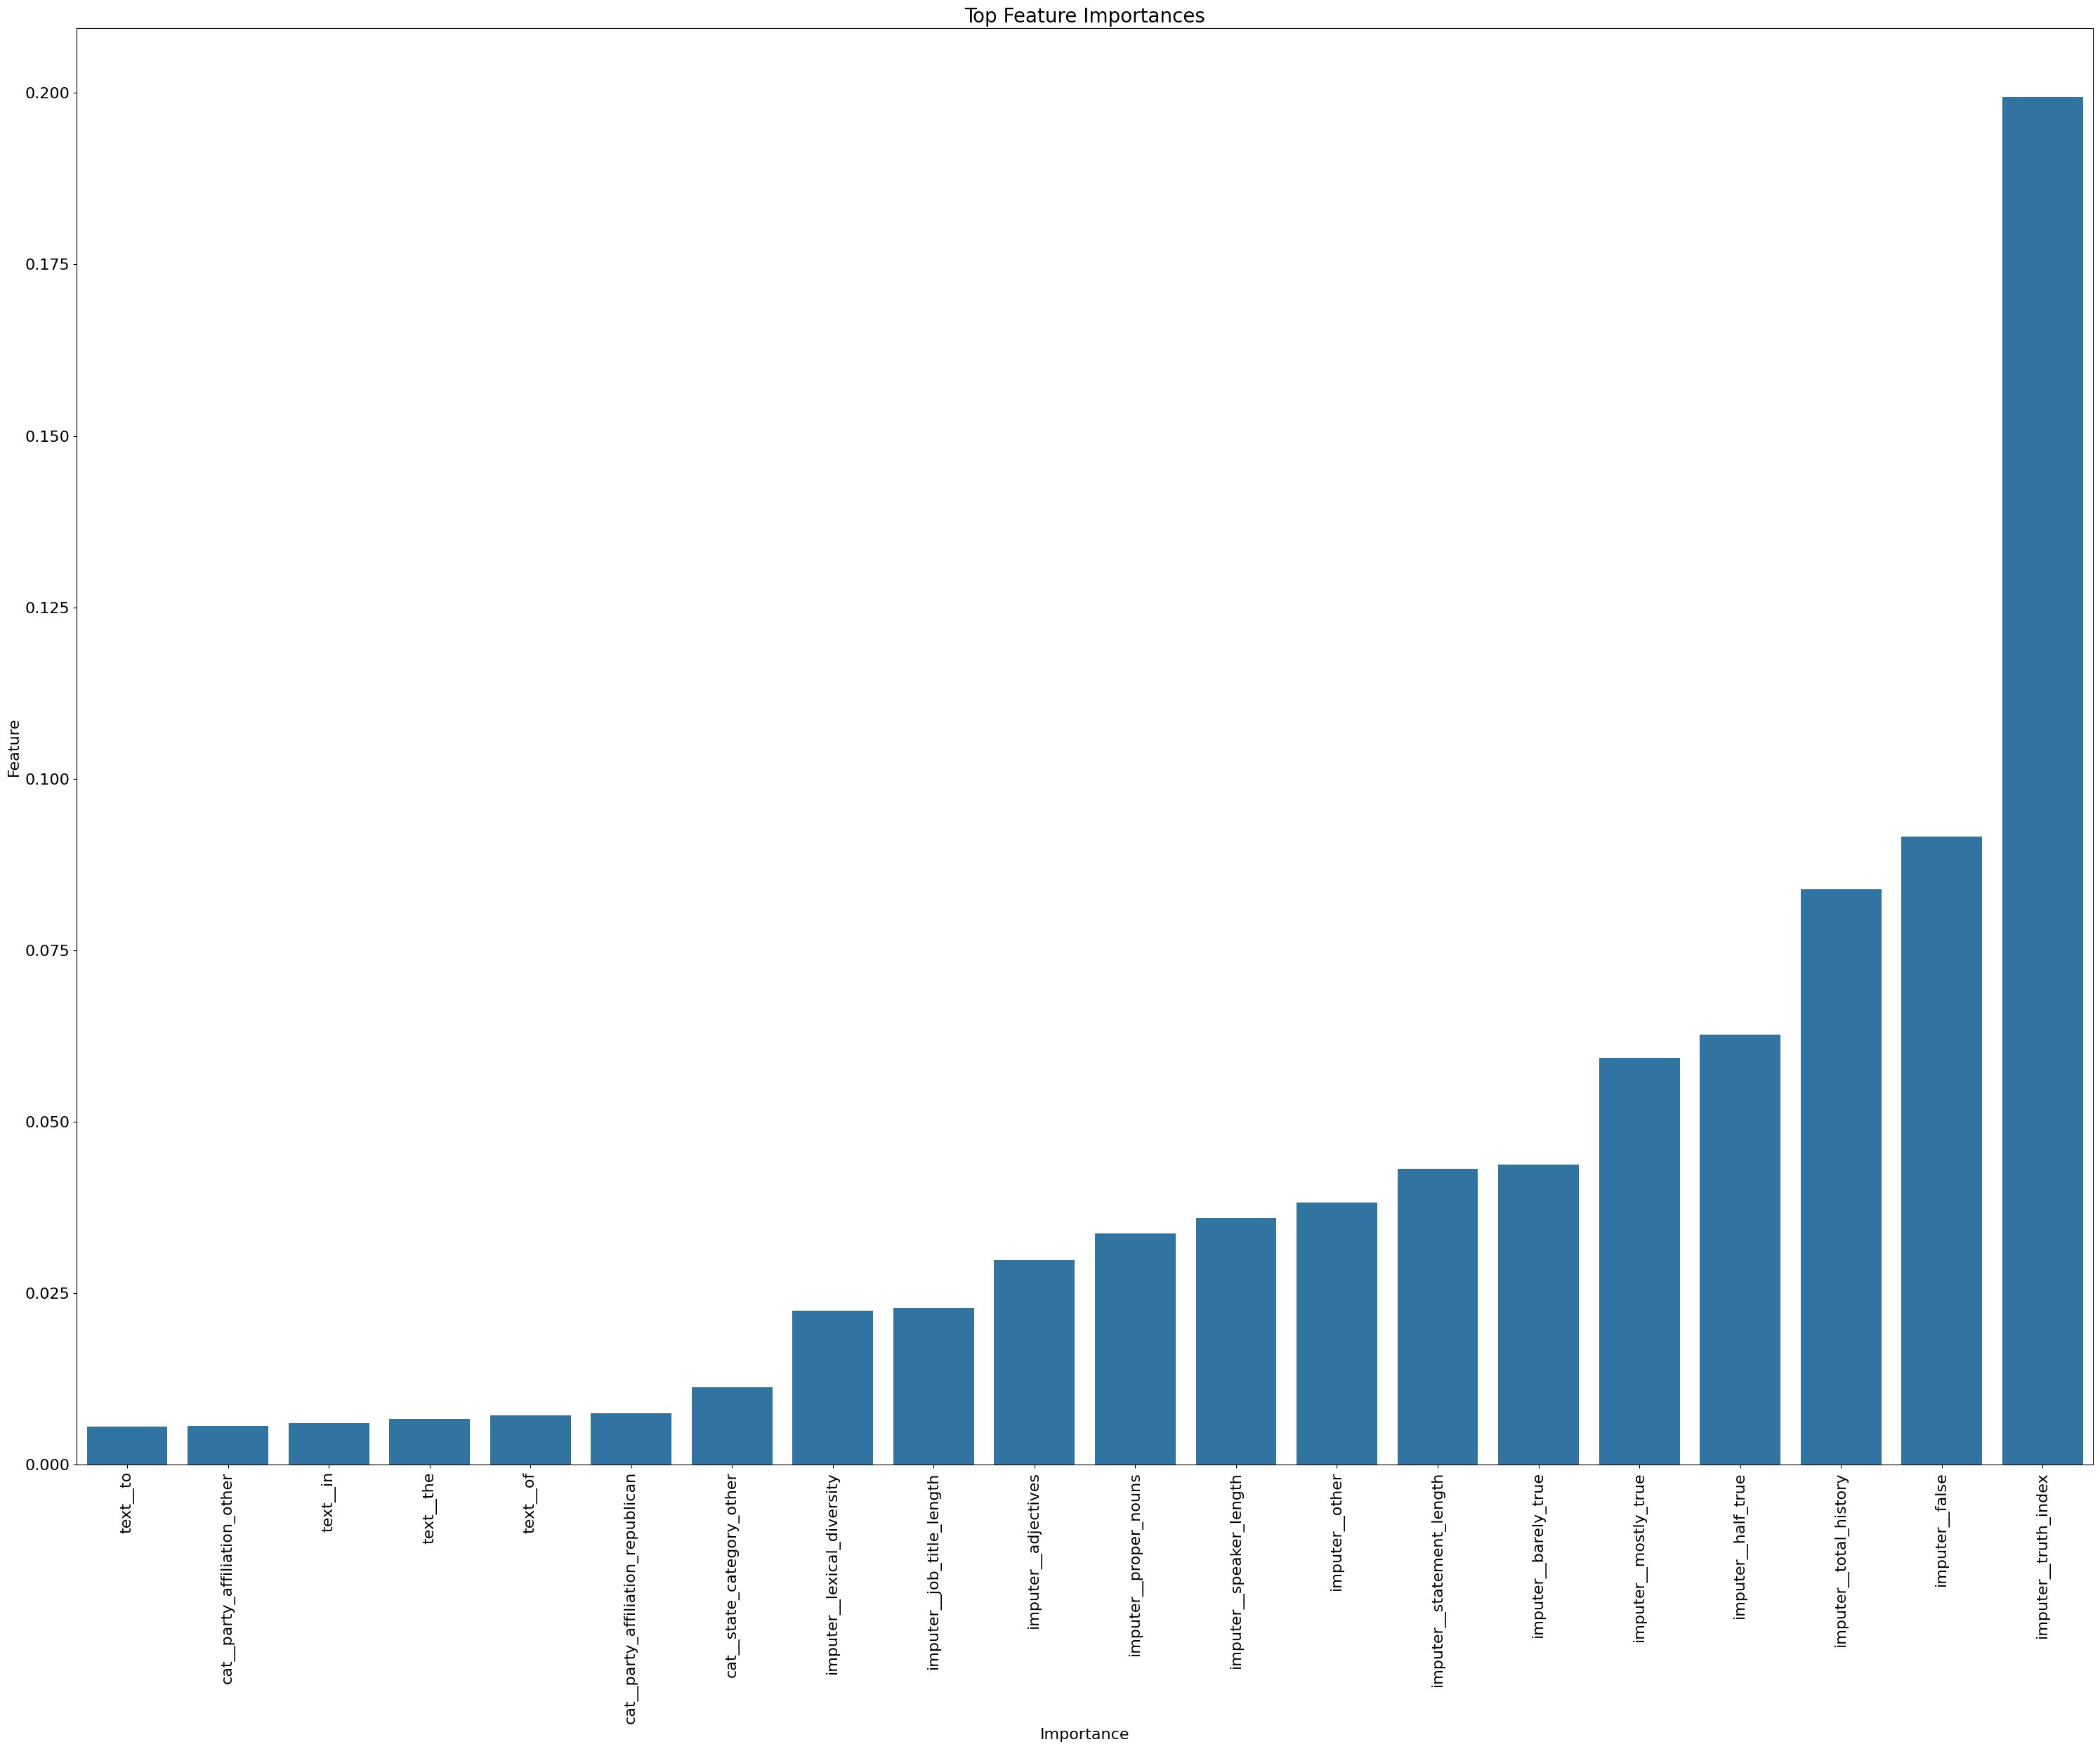

In [25]:
categorical_cols = ['state_category', 'party_affiliation']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('text', CountVectorizer(), 'statement'),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
model = grid_search_decision_tree(X_combined, y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test), "Decision Tree", model)
plot_feature_importances(model)

We get a result which is slightly worse, next we will try removing the stopwords

F1 Score: 0.475


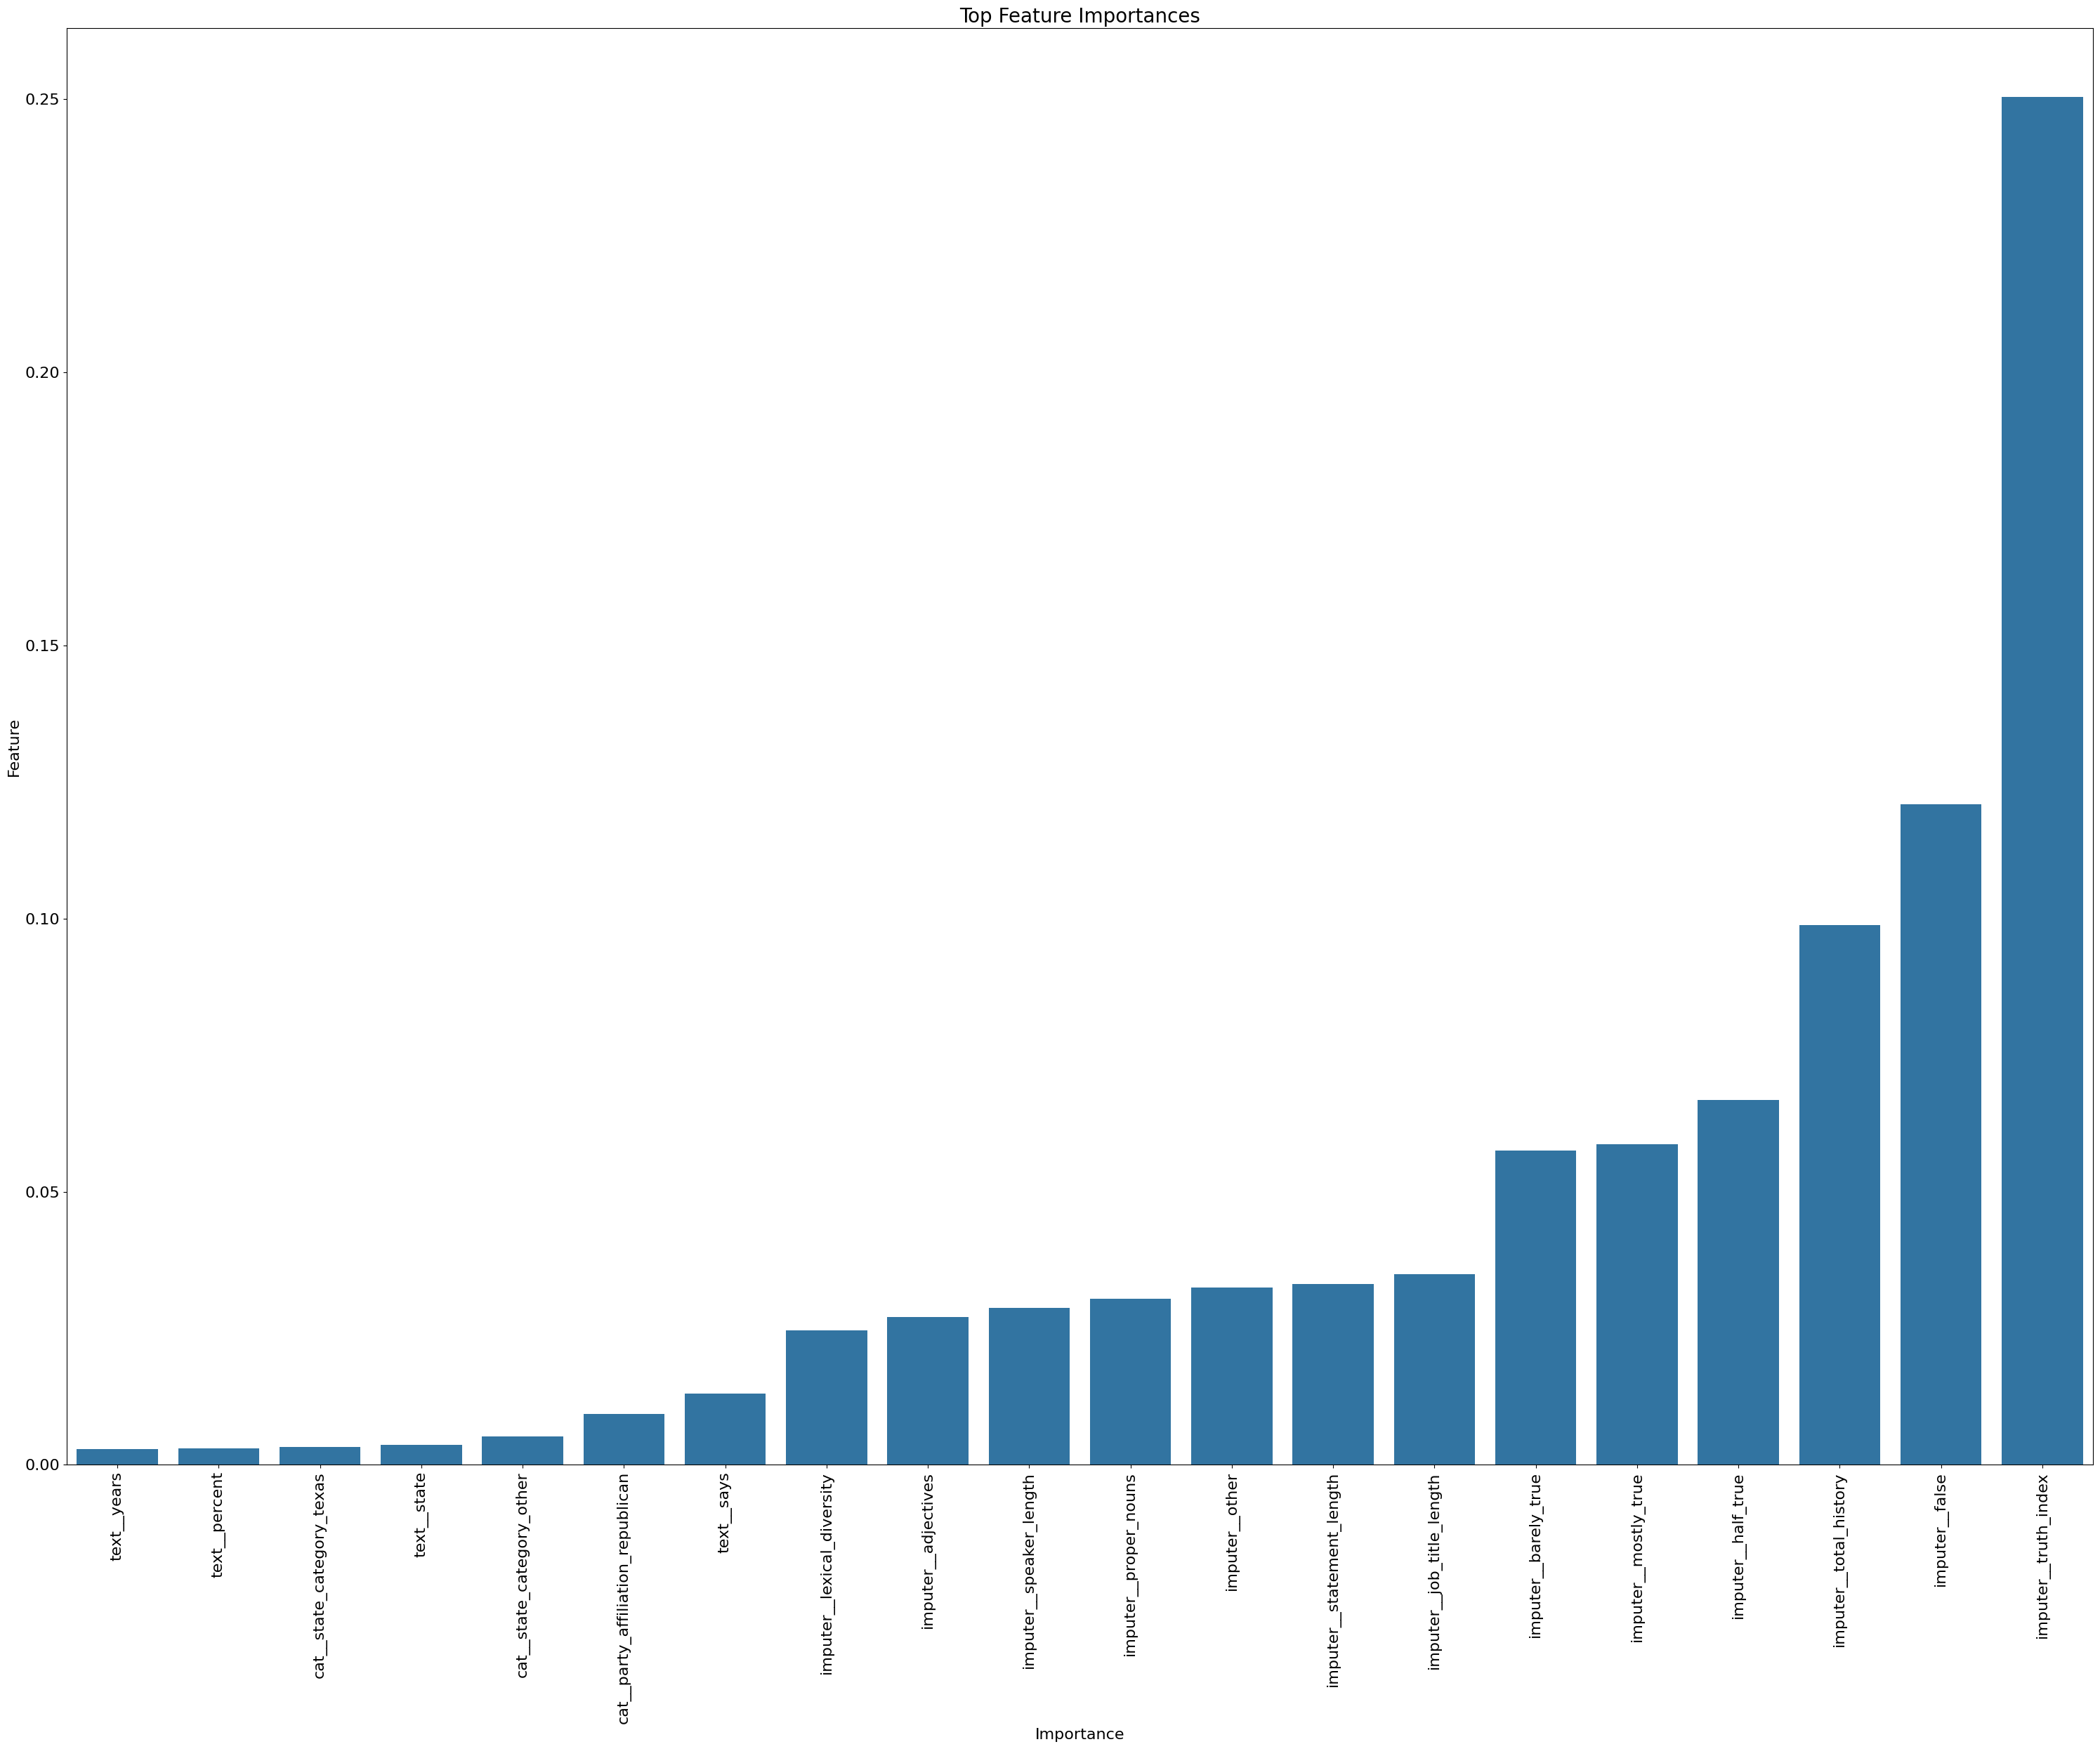

In [26]:
categorical_cols = ['state_category', 'party_affiliation']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english'), 'statement'),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
model = grid_search_decision_tree(X_combined, y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test), "Decision Tree", model)
plot_feature_importances(model)

A little better, we should try be combining 2 words(bigrams)

F1 Score: 0.483


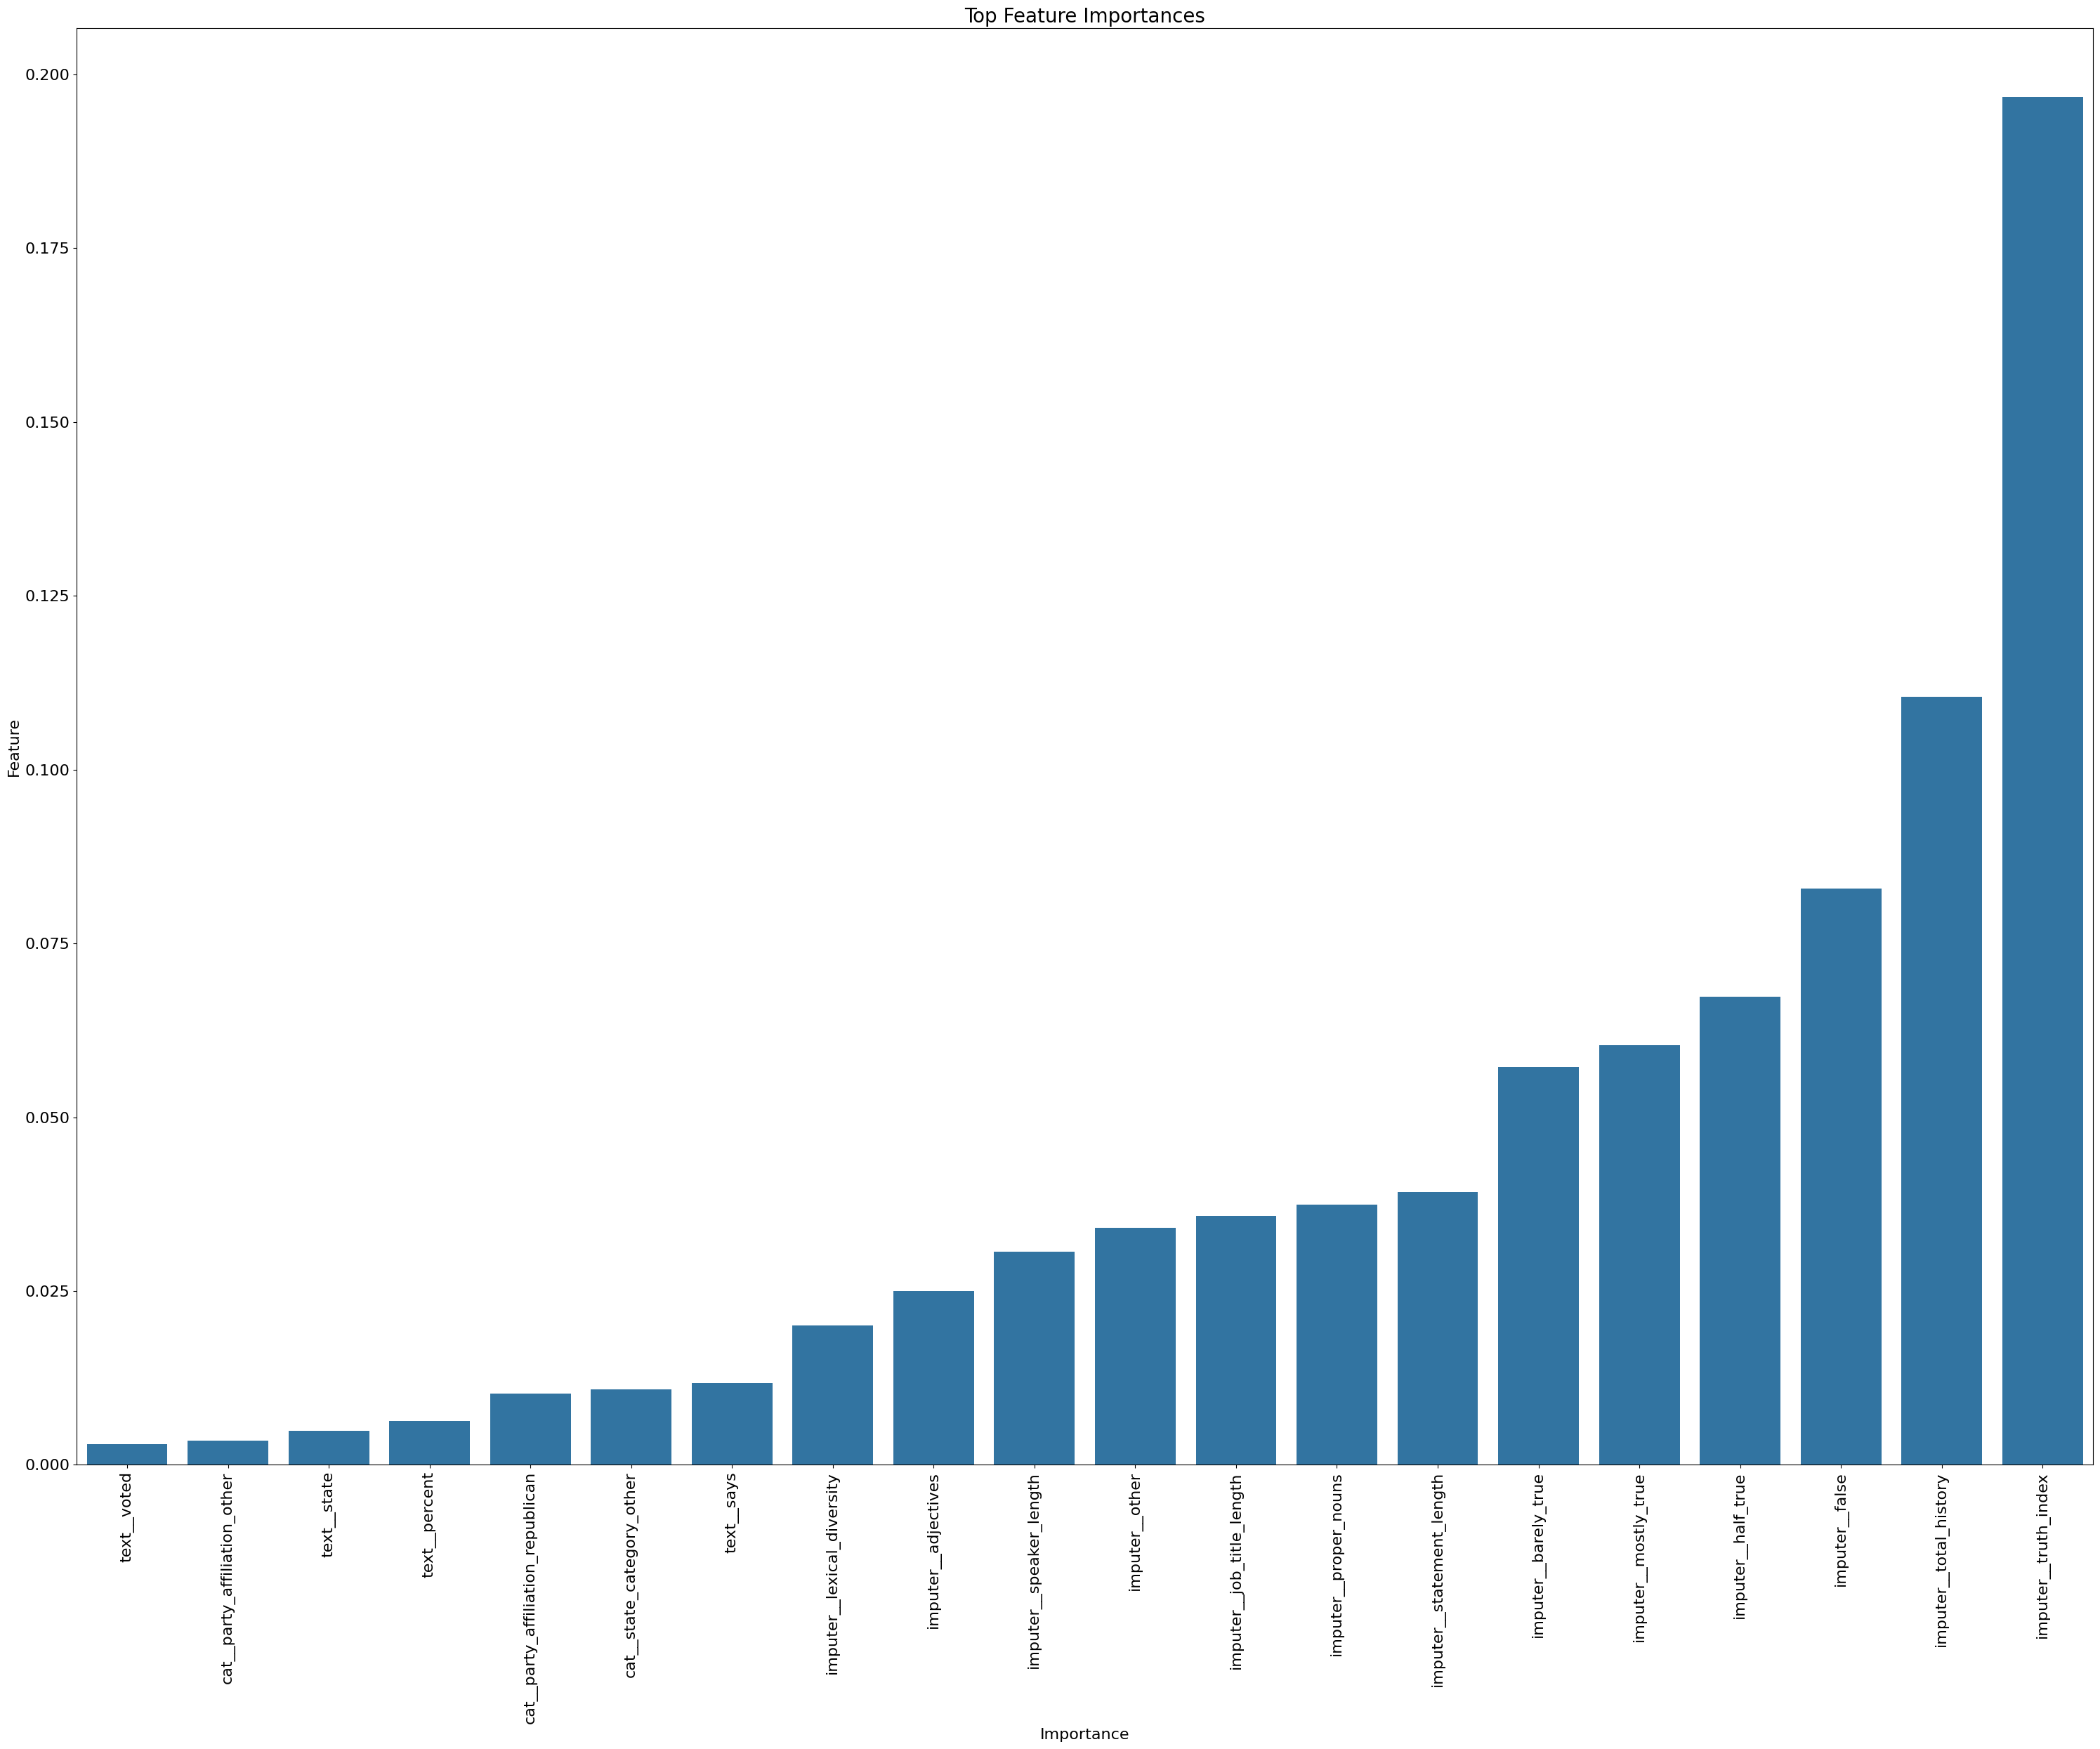

In [27]:
categorical_cols = ['state_category', 'party_affiliation']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english', ngram_range=(1, 2)), 'statement'),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
model = grid_search_decision_tree(X_combined, y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test), "Decision Tree", model)
plot_feature_importances(model)

In [28]:
def stemmed_tokenizer(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

Now this is better, what we could do next is stemming

d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 't

F1 Score: 0.478


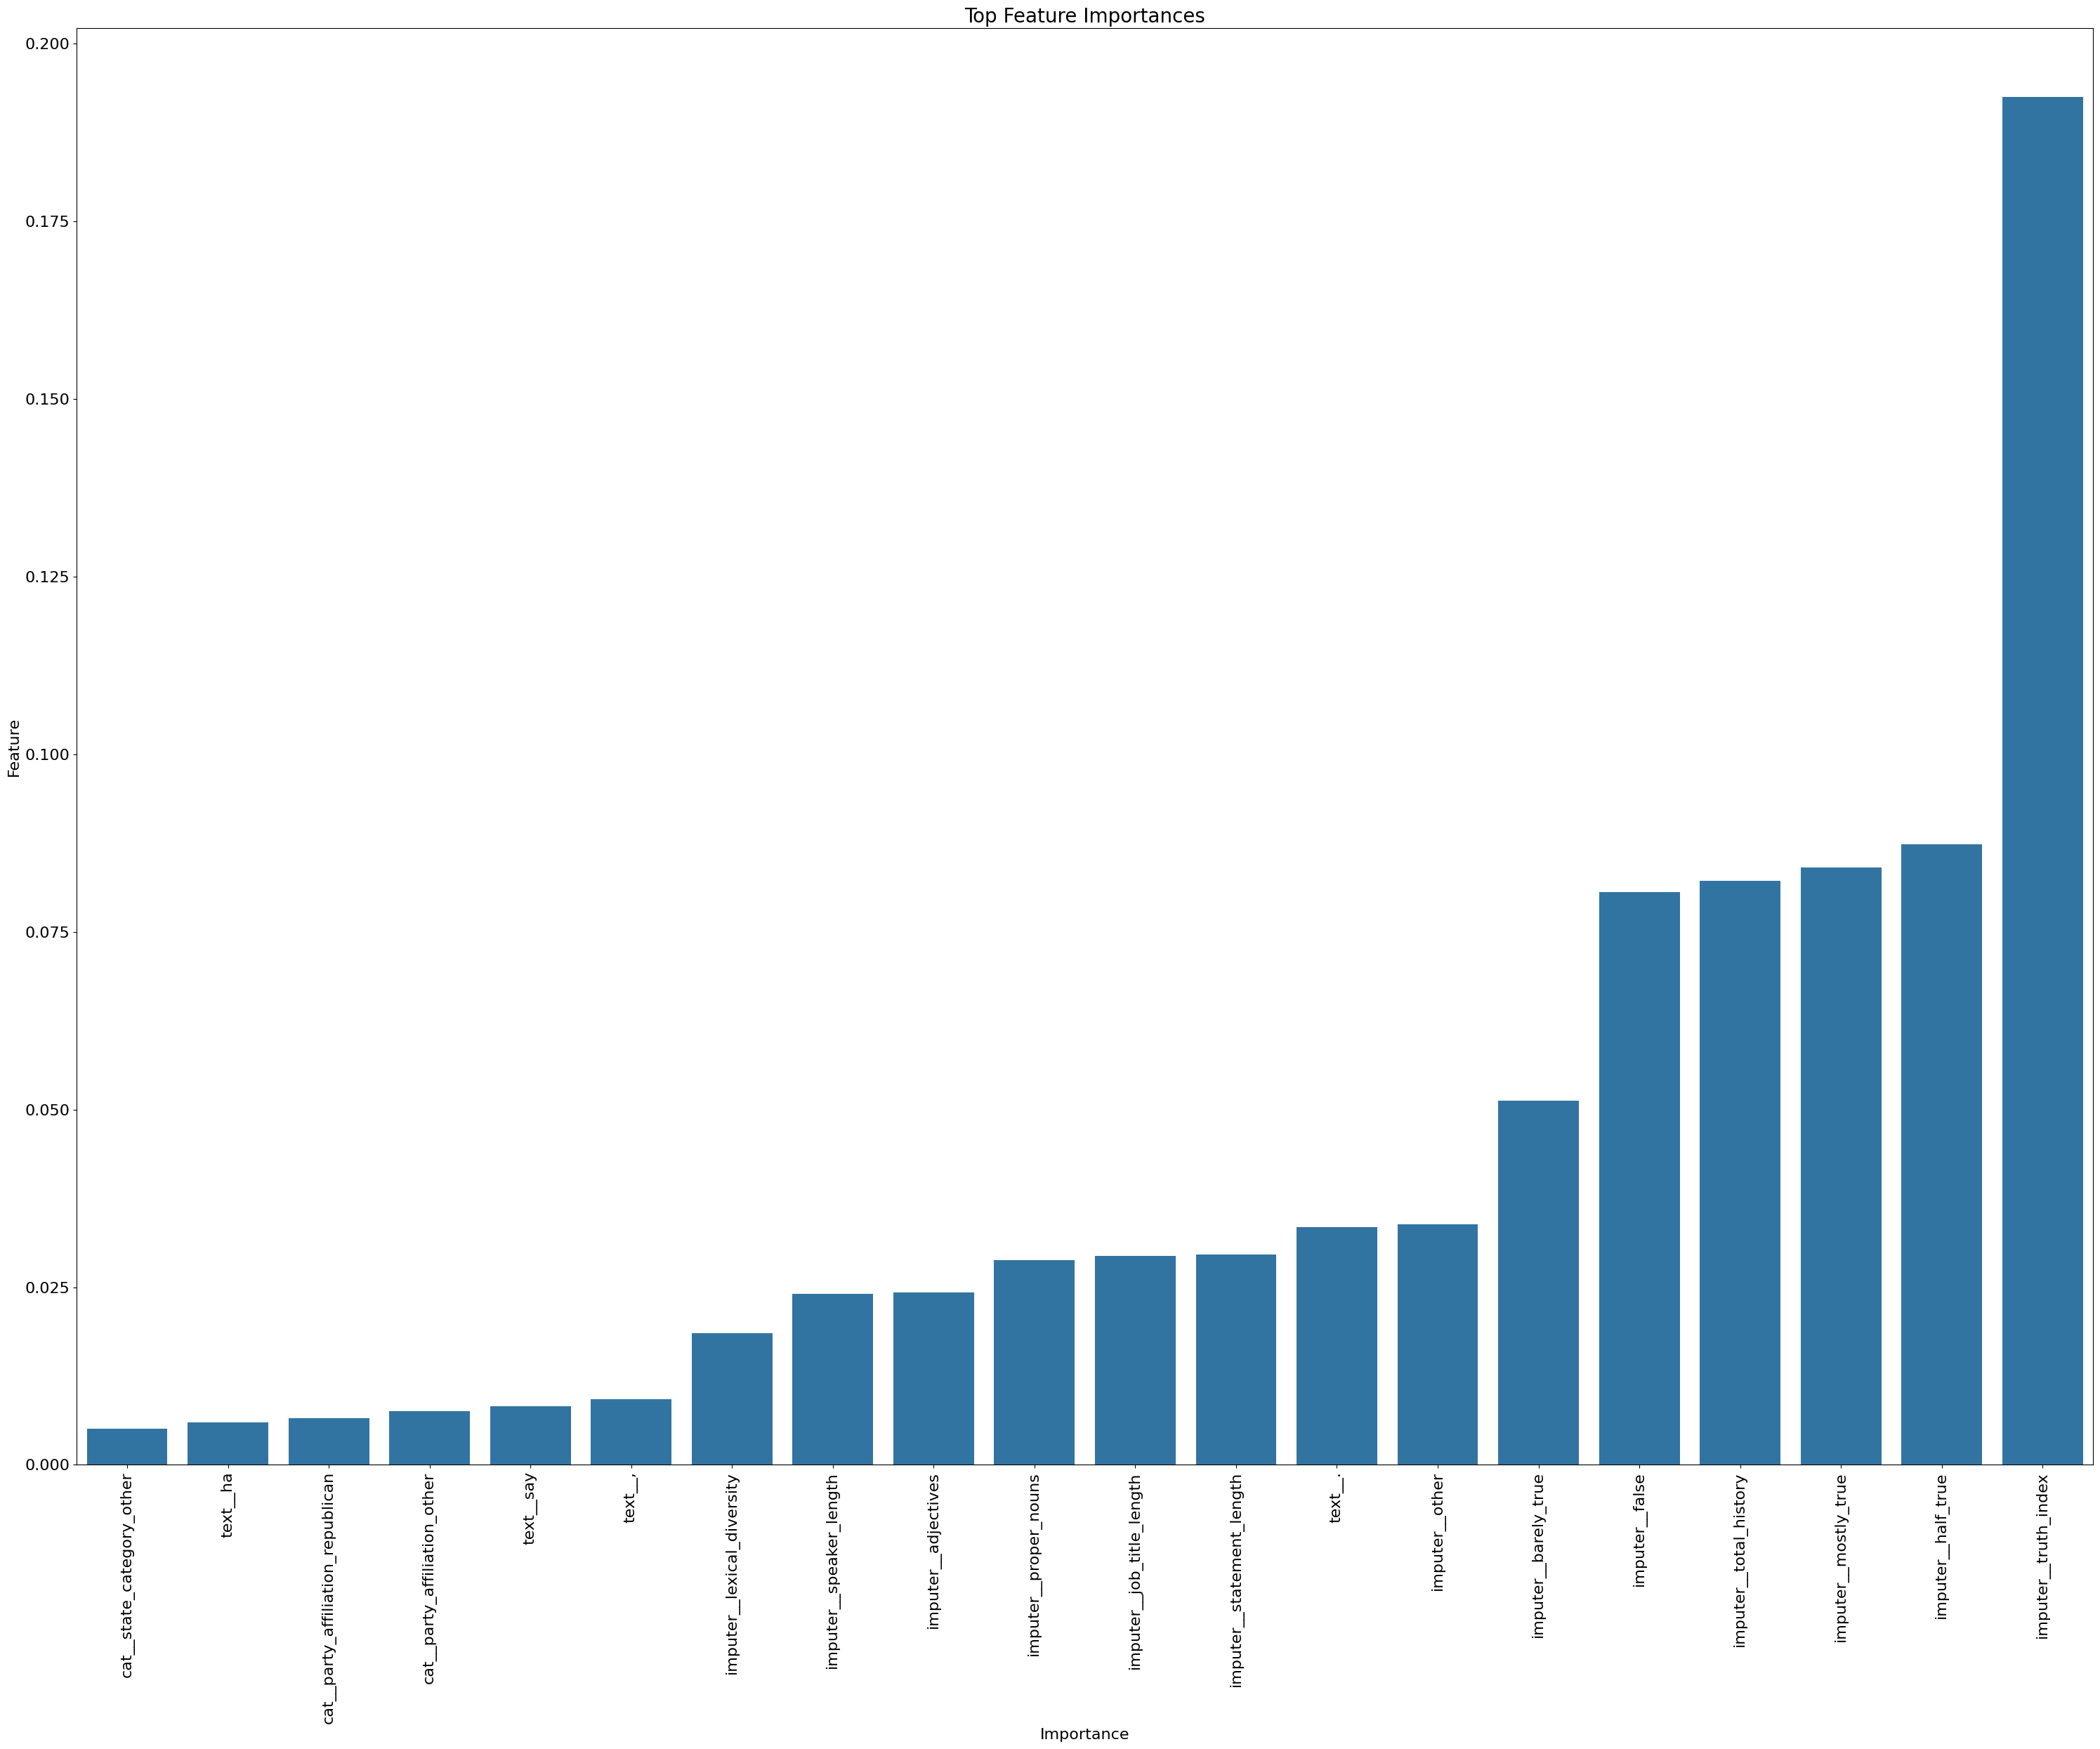

In [29]:
categorical_cols = ['state_category', 'party_affiliation']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(tokenizer = stemmed_tokenizer, stop_words='english', ngram_range=(1, 2)), 'statement'),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
model = grid_search_decision_tree(X_combined, y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test), "Decision Tree", model)
plot_feature_importances(model)

We get a little worse result, so we will not use stemming, also because it it makes the programm run much slower.

One last try with count vectorizer

F1 Score: 0.476


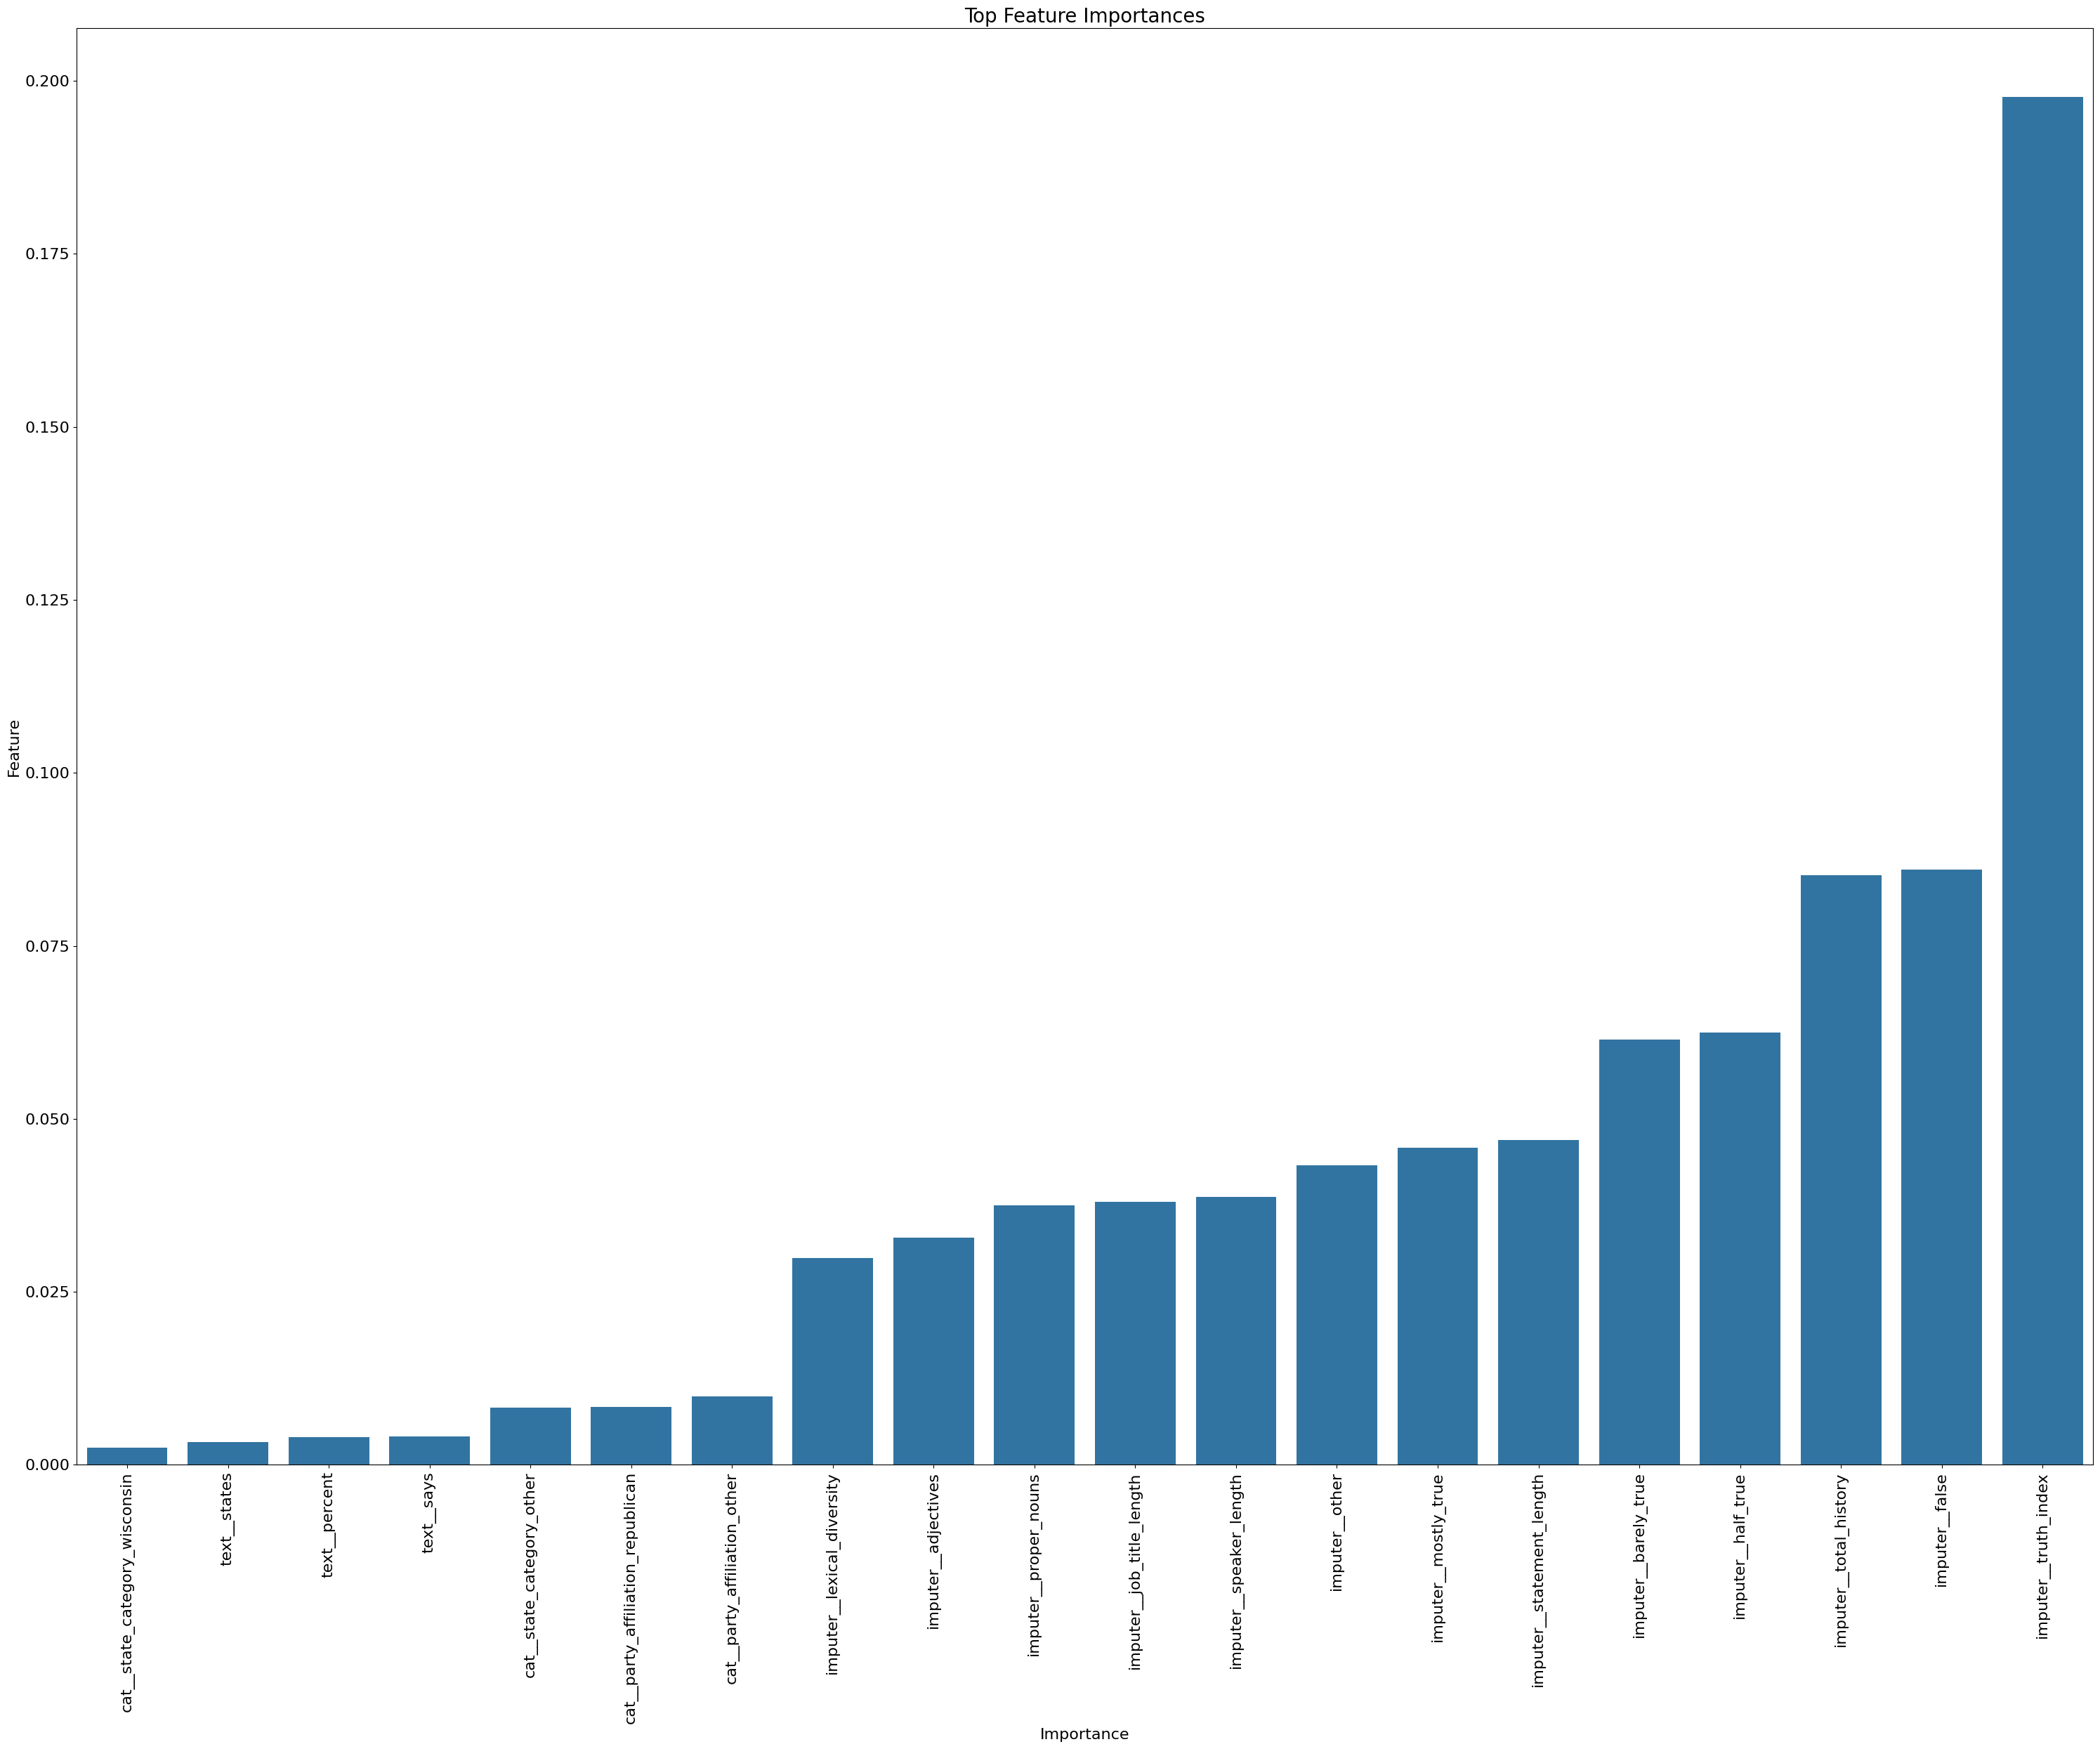

In [30]:
categorical_cols = ['state_category', 'party_affiliation']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('text', CountVectorizer(stop_words='english', ngram_range=(1, 2)), 'statement'),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
model = grid_search_decision_tree(X_combined, y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test), "Decision Tree", model)
plot_feature_importances(model)

Excellent! We got an 0.483 f1 score so this will be our best model. Let us save the results to excel

In [31]:
save_to_excel(report)

So this is our best model

In [13]:
categorical_cols = ['state_category', 'party_affiliation']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english', ngram_range=(1, 2)), 'statement'),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, max_depth = 25, min_samples_split = 2, min_samples_leaf = 1, criterion = 'entropy'))
])
pipeline.fit(X_combined, y_combined)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
print(f"F1 Score: {f1:.3f}")
cm = confusion_matrix(y_test, y_pred)

F1 Score: 0.483


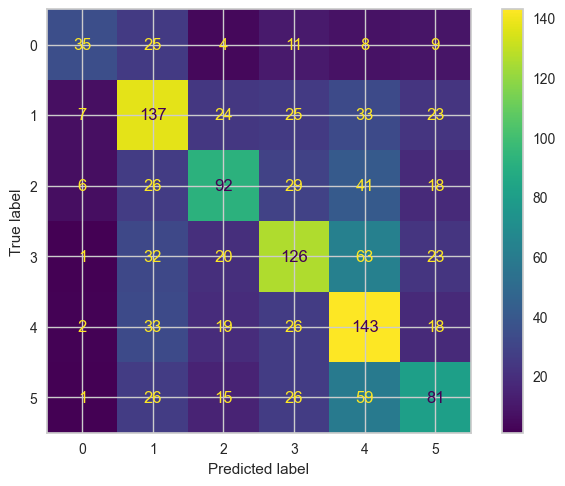

In [14]:
ConfusionMatrixDisplay(cm).plot()

plt.show()

AttributeError: 'float' object has no attribute 'show'

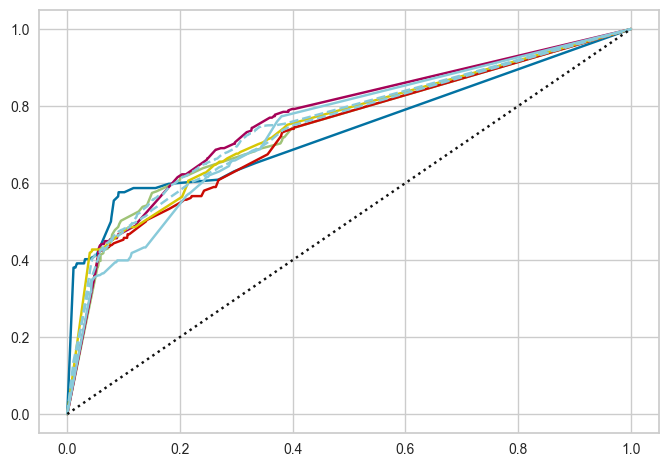

In [15]:
visualizer = ROCAUC(pipeline, classes=[0,1,2,3,4,5]).fit(X_train, y_train).score(X_test, y_test).show()